## Smart Alarm Single Machine Classifier Training

In [1]:
!pip -q install tensorly

     |████████████████████████████████| 163kB 7.8MB/s 
     |████████████████████████████████| 163kB 39.5MB/s 


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!nvidia-smi

Thu May 20 08:03:14 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Imports

In [45]:
import numpy as np
%matplotlib inline
import csv
import os
import sys
import pickle
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
# Imported Libraries
import time
import gc
# Classifier Libraries
import collections
import warnings
import torch
import tensorly as tl
tl.set_backend('pytorch')
warnings.filterwarnings("ignore")
import statsmodels.api as sm
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, LSTM,MaxPooling2D,Conv2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso, LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report, confusion_matrix
from tensorly import unfold as tl_unfold
from tensorly.decomposition import parafac
from tensorly.regression.tucker_regression import TuckerRegressor


# Green Alarms

In [ ]:
root_folder="/content/drive/MyDrive/Test"
def generate_stats(root_folder):
    green_alarms =["A1","A17","A19","A23","A25","A29","A35","A315"]
    files=os.listdir(root_folder)
    lst=[]
    for f in files:
        if os.path.isdir(os.path.join(root_folder,f)):
            pwd = os.path.join(root_folder,f)
            y = pd.read_csv(os.path.join(pwd,"y.csv"),header=None)
            labels=pd.read_csv(os.path.join(pwd,"classes.csv"),header=None)
            alrm='folder:'+f+' alarm'
            labels.columns=[alrm]
            fd = pd.DataFrame(np.zeros((len(labels),1)),columns=['count'])
            dfs = pd.concat([labels,fd], axis=1)
            for i,row in dfs.iterrows():
                cnt=np.sum(y==i)
                dfs.loc[i,'count']=cnt[0]
            lst.append(dfs)
    new_lst=[]
    for df in lst:
        s=pd.DataFrame(np.zeros(df.shape[0]),columns=['green_alarm'])
        s=pd.concat([df,s],axis=1)
        for i,row in df.iterrows():
            if row.iloc[0] in green_alarms:
                s.loc[i,'green_alarm']='green'
            else:
                s.loc[i,'green_alarm']='irrelevent'
        new_lst.append(s)
    return new_lst

In [ ]:
new_lst = generate_stats(root_folder)

FileNotFoundError: ignored

In [ ]:
new_lst

# Define compact functions

In [5]:
def load_data(root_folder):
    try:
        x_train = np.load(os.path.join(root_folder,'x_train_vec.npy'))
        x_test = np.load(os.path.join(root_folder,'x_test_vec.npy'))
        y_train = np.load(os.path.join(root_folder,'y_train_vec.npy'))
        y_test = np.load(os.path.join(root_folder,'y_test_vec.npy'))
    except:
        csv_to_numpy(root_folder,total_rows = 500)
        train_test_split_data(root_folder)
        x_train = np.load(os.path.join(root_folder,'x_train_vec.npy'))
        x_test = np.load(os.path.join(root_folder,'x_test_vec.npy'))
        y_train = np.load(os.path.join(root_folder,'y_train_vec.npy'))
        y_test = np.load(os.path.join(root_folder,'y_test_vec.npy'))
    return x_train,y_train,x_test,y_test

In [6]:
def break_csv(source_filepath, dest_path, result_filename_prefix, row_limit):
    """
    Break a source CSV into multiple CSVs of equal numbers of records,
    except the last file.
    The initial file's header row will be included as a header row in each split
    file.
    Split files follow a zero-index sequential naming convention like so:
        `{result_filename_prefix}_0.csv`
    :param source_filepath {str}:
        File name (including full path) for the file to be split.
    :param dest_path {str}:
        Full path to the directory where the split files should be saved.
    :param result_filename_prefix {str}:
        File name to be used for the generated files.
    :param row_limit {int}:
        Number of rows per file (header row is excluded from the row count).
    :return {NoneType}:
    """
    if row_limit <= 0:
        raise Exception('row_limit must be > 0')
    if not os.path.exists(dest_path):
        os.mkdir(dest_path)
    with open(source_filepath, 'r') as source:
        reader = csv.reader(source)
        headers = next(reader)
        file_number = 0
        records_exist = True
        while records_exist:
            i = 0
            target_filename = f'{result_filename_prefix}_{file_number}.csv'
            target_filepath = os.path.join(dest_path, target_filename)
            with open(target_filepath, 'w') as target:
                writer = csv.writer(target)
                while i < row_limit:
                    if i == 0:
                        writer.writerow(headers)
                    try:
                        writer.writerow(next(reader))
                        i += 1
                    except:
                        records_exist = False
                        break
            if i == 0:
                os.remove(target_filepath)
            file_number += 1

In [7]:
def csv_to_numpy(root_dir,total_rows = 500):
    source = os.path.join(root_dir,"X_range_local.csv")
    y_path = os.path.join(root_dir,"y.csv")
    try: 
        df = pd.read_csv(source)
        arr = np.array(df)
        arr_y = pd.read_csv(y_path)
    except:
        dest_x = os.path.join(root_dir,"new")
        filname_prefix = "X_range_local"
        break_csv(source, dest_x, filname_prefix, total_rows)
        os.remove(os.path.join(dest_y,"y_29.csv"))
        source_y = os.path.join(root_dir,"y.csv")
        dest_y = os.path.join(root_dir,"newest_y")
        filname_prefix_y = "y"
        break_csv(source_y, dest_y, filname_prefix_y, total_rows)
        os.remove(os.path.join(dest_x,"X_range_local_29.csv")) 

        pwd = os.path.join(root_dir,dest_x)
        filenames = os.listdir(pwd)
        np_dest_x =  os.path.join(root_dir,"X_range_np")
        print("="*29)
        if os.listdir(np_dest_x) ==[]:
            for f in filenames:
                df_mini = pd.read_csv(os.path.join(pwd,f))
                new_arr = np.array(df_mini)
                if not os.path.exists(np_dest_x):
                    os.mkdir(np_dest_x)
                np_path= f.split('_')[-1]
                np_path= os.path.join(np_dest_x,np_path.split('.')[0]+".npy")
                np.save(np_path,new_arr)
                print("=",end='')
        pwd = os.path.join(root_dir,dest_y)
        filenames = os.listdir(pwd)
        np_dest =  os.path.join(root_dir,"y_np")
        print("="*29)
        if os.listdir(np_dest) ==[]:
            for f in filenames:
                df_mini = pd.read_csv(os.path.join(pwd,f))
                new_arr = np.array(df_mini)
                if not os.path.exists(np_dest):
                    os.mkdir(np_dest)
                np_path= f.split('_')[-1]
                np_path= os.path.join(np_dest,np_path.split('.')[0]+".npy")
                np.save(np_path,new_arr)
                print("=",end='')
        pwd =  np_dest_x
        filenames = os.listdir(pwd)
        dirlist = sorted_alphanumeric(filenames)
        dirlist.reverse()
        arr = np.array([])
        print("="*20)

        for f in dirlist[9:]:
            path_new=os.path.join(os.path.join(pwd,f))
            s=np.load(path_new)
            if len(arr.shape) < 2:
                arr = s
            elif arr.shape[0]==10000:
                break
            else:
                arr=np.vstack([s,arr])
            del s
            gc.collect()
            print("=",end='')
        pwd = np_dest
        filenames = os.listdir(pwd)
        dirlist = sorted_alphanumeric(filenames)
        dirlist.reverse()
        arr_y = np.array([])
        print("="*20)
        for f in dirlist[9:]:
            path_new=os.path.join(os.path.join(pwd,f))
            s=np.load(path_new)
            if arr_y.shape == (0,):
                arr_y = s
            elif arr_y.shape[0]==10000:
                break
            else:
                arr_y=np.vstack([s,arr_y])
            del s
            gc.collect()
            print("=",end='')
    np_save_path_x = os.path.join(root_dir,'X_range_local_10k.npy')
    np.save(np_save_path_x,arr)
    np_save_path_y = os.path.join(root_dir,'y2_10k.npy')
    np.save(np_save_path_y,arr_y)
    print(np_save_path_x,np_save_path_y)


In [8]:
import re
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ] 
    return sorted(data, key=alphanum_key)


In [9]:
def train_test_split_data(root_dir):
    arr = np.load(os.path.join(root_dir,'X_range_local_10k.npy'))
    arr_y = np.load(os.path.join(root_dir,'y2_10k.npy'))
    time =  pd.read_csv(os.path.join(root_dir,"times_id.csv"),header=None)
    feature =  pd.read_csv(os.path.join(root_dir,"features_id.csv"),header=None)
    time = np.max(np.asarray(time))
    feature = np.max(np.asarray(feature))
    arr = arr.reshape(arr.shape[0],feature,time)
    x_train, x_test, y_train, y_test = train_test_split(arr, arr_y, test_size=0.3, random_state=42)
    np_path=root_dir
    np.save(os.path.join(np_path,'x_train_vec.npy'),x_train)
    np.save(os.path.join(np_path,'x_test_vec.npy'),x_test)
    np.save(os.path.join(np_path,'y_train_vec.npy'),y_train)
    np.save(os.path.join(np_path,'y_test_vec.npy'),y_test)


In [10]:
def feature_extract_list(x_train,y_train,x_test,y_test,sensor_names):
    features=pd.read_csv('features.csv',header=None)
    sensor_idxs=[]
    for i in range(len(features.values)):
        if features.values[i] in sensor_names:
            sensor_idxs.append(i)
    train_df = np.take(x_train,sensor_idxs,axis=1)
    test_df = np.take(x_test,sensor_idxs,axis=1)
    return train_df, test_df

In [11]:
def feature_extract_lasso(x_train,y_train,x_test,y_test):
    features=pd.read_csv(os.path.join(root_dir,'features.csv'),header=None)
    new_mat = x_train.mean(axis=-1,keepdims=1)
    new_mat=new_mat.reshape((x_train.shape[0],x_train.shape[1]))
    new_mat=np.hstack([new_mat,y_train])
    fets=features
    fets=fets.append(['y'])
    df=pd.DataFrame(new_mat,columns=fets)
    reg = LassoCV()
    reg.fit(new_mat[:,:-1], new_mat[:,-1])
    print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
    print("Best score using built-in LassoCV: %f" %reg.score(new_mat[:,:-1], new_mat[:,-1]))
    coef = pd.Series(reg.coef_, index = features)
    print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")
    imp_coef = coef.sort_values()
    features_list=[]
    for val,s in imp_coef.items():
        if s>0 or s<0:
            features_list.append(val[0])
    sensor_idxs_fe=[]
    for i in range(len(features.values)):
        if features.values[i] in features_list:
            sensor_idxs_fe.append(i)
    train_df_lasso_fe = np.take(x_train,sensor_idxs_fe,axis=1)
    test_df_lasso_fe = np.take(x_test,sensor_idxs_fe,axis=1)
    return train_df_lasso_fe,test_df_lasso_fe

In [12]:
import itertools

# Create a confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [13]:
def apply_pca(x_train,x_test,PCA_components=20):
    pca_col = ["pca"+str(i+1) for i in range(PCA_components)]
    pca = PCA(n_components=PCA_components)
    principalComponents = pca.fit_transform(x_train) #train and transform training set
    X_train_pca = principalComponents
    print(X_train_pca.shape)
    X_test_pca = pca.transform(x_test) #dont train just transform test set
    print(X_test_pca.shape)
    return X_train_pca, X_test_pca

In [14]:
def apply_cp_decomposition(x_train, x_test, cp_components=5):
    X, rank = x_train, cp_components
    X = X.astype('float') #chaning integar type of x_train to float for cp decomposition
    X = tl.tensor(X) #convert to datatype TENSOR
    del x_train # memory save
    print(X.shape)
    factors_tl = parafac(X, rank=rank)
    weights,factors = factors_tl
    factor_matrix = factors[1]
    X=torch.transpose(X, 1, 2)           #swap axes for dot product of matrices
    latent_feature_matrix = np.dot(X,factor_matrix) # Multiply x_train=X with factor matrix of features 
    print(latent_feature_matrix.shape)
    flatten_latent_FM_train = np.reshape(latent_feature_matrix,(X.shape[0],X.shape[1]*cp_components))
    X_test, rank = x_test, 20
    X_test = X_test.astype('float')
    X_test = tl.tensor(X_test)
    X_test=torch.transpose(X_test, 1, 2)
    latent_feature_matrix_test = np.dot(X_test,factor_matrix)
    flatten_latent_FM_test = np.reshape(latent_feature_matrix_test,(X_test.shape[0],X_test.shape[1]*cp_components)) #flatten for training ML model
    return flatten_latent_FM_train, flatten_latent_FM_test

In [15]:
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import NeighbourhoodCleaningRule
def undersample(x_train,y_train):
    Y_train = np.ravel(y_train)
    # summarize class distribution
    c= Counter(Y_train)
    last=c.most_common()[-1][1]
    second=c.most_common()[1][1]

    # define undersample strategy
    undersample = NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5)
    # fit and apply the transform
    X_over, Y_over = undersample.fit_resample(x_train, Y_train)
    print(X_over.shape, Y_over.shape)
    print(Counter(Y_over))

    return X_over, Y_over.reshape(Y_over.shape[0],1) 



In [16]:
from tensorflow.keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


In [17]:
def frame_and_TG_selection(window_sizes,TG,X_train,Y_train,X_test,Y_test,model='none', feature_extract='none',
                           feature_extract_lst='none', undersample_data=False, pca=False,cp_decompose=False,
                           K=2,labels = ['A10','A137_UVR_1','A138_UVR_1','A315','A501','A502','A77','Normal']):
    preds=[]
    y_over=[]

    labels= pd.read_csv(root_dir+'\\classes.csv',header=None)
    labels = labels.values
    for w, tg in zip(window_sizes,TG):
        if feature_extract=='lasso':
            x_train,x_test=feature_extract_lasso(X_train,Y_train,X_test,Y_test)
            y_train, y_test= Y_train,Y_test

        elif feature_extract=='list' and feature_extract_lst !='none':
            x_train,x_test=feature_extract_list(X_train,Y_train,X_test,Y_test,feature_extract_lst)
            y_train, y_test= Y_train,Y_test
        else:
            x_train, y_train, x_test, y_test= X_train,Y_train,X_test,Y_test
        if undersample_data:
            x_train_re = x_train.reshape((x_train.shape[0],x_train.shape[1]*x_train.shape[2]))
            x_train_re, y_train = undersample(x_train_re, y_train)
            x_train = x_train_re.reshape((x_train_re.shape[0],x_train.shape[1],x_train.shape[2]))
            labels=[]
            labels_name= pd.read_csv(root_dir+'\\classes.csv',header=None)
            y_over=y_train
            c=(Counter(np.ravel(y_train)))
            for i,n in c.most_common():
                labels.append(labels_name.iloc[i][0])
            labels.reverse()
        window_step = w*60//5
        x_train_windowed = x_train[:,:,-window_step:]
        x_train_windowed = x_train_windowed[:,:,::tg//5]
        x_test_windowed = x_test[:,:,-window_step:]
        x_test_windowed = x_test_windowed[:,:,::tg//5]
        if pca:
            x_train_windowed = x_train_windowed.reshape((x_train_windowed.shape[0],x_train_windowed.shape[1]*x_train_windowed.shape[2]))
            x_test_windowed = x_test_windowed.reshape((x_test_windowed.shape[0],x_test_windowed.shape[1]*x_test_windowed.shape[2]))
            x_train_windowed, x_test_windowed = apply_pca(x_train_windowed, x_test_windowed)
        
        if cp_decompose:
            x_train_windowed,x_test_windowed=apply_cp_decomposition(x_train_windowed,x_test_windowed)
        if model =='LSTM':
            if cp_decompose:
                x_train_windowed=x_train_windowed.reshape(X_train.shape[0],X_train.shape[2],
                                                          x_train_windowed.shape[1]//X_train.shape[2])
                x_test_windowed=x_test_windowed.reshape(X_test.shape[0],X_test.shape[2],
                                          x_test_windowed.shape[1]//X_test.shape[2])
                x_train_windowed = torch.transpose(tl.tensor(x_train_windowed), 1, 2)
                x_test_windowed = torch.transpose(tl.tensor(x_test_windowed), 1, 2)
            x_train_windowed = torch.transpose(tl.tensor(x_train_windowed), 1, 2)
            x_test_windowed = torch.transpose(tl.tensor(x_test_windowed), 1, 2)
            n_steps=x_train_windowed.shape[1]
            n_features=x_train_windowed.shape[2]
            print(n_steps,n_features)
            x_train_windowed = np.array(x_train_windowed)
            x_test_windowed = np.array(x_test_windowed)
            y_train = to_categorical(y_train)
            y_test = to_categorical(y_test)
            # reshape from [samples, timesteps] into [samples, timesteps, features]
            LSTM_model = Sequential()
            LSTM_model.add(LSTM(100, input_shape=(n_steps,n_features)))
            LSTM_model.add(Dense(100, activation='relu'))
            LSTM_model.add(Dense(np.argmax(y_train)+1, activation='softmax'))
            LSTM_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc',f1_m,precision_m, recall_m])
            LSTM_model.summary()
            history=LSTM_model.fit(x_train_windowed, y_train, epochs=10, verbose=1, validation_split=0.2)
            # demonstrate prediction
            pred = LSTM_model.predict(x_train_windowed, verbose=1)
            pred_test = LSTM_model.predict(x_test_windowed, verbose=1)
            training_score = LSTM_model.evaluate(x_train_windowed,y_train)
            test_score  = LSTM_model.evaluate(x_test_windowed,y_test)
            pred= np.argmax(pred, axis=1)
            pred_test= np.argmax(pred_test, axis=1)

            preds.append(pred)
            y_train = np.argmax(y_train, axis=1)
            y_test = np.argmax(y_test, axis=1)
            LSTM_pred = confusion_matrix(y_train, pred)
            LSTM_pred_test = confusion_matrix(y_test, pred_test)
            labels_idx=list(set(s for s in y_train.tolist()))
            labels_idx.sort()
            labels_idx_test=list(set(s for s in y_test.tolist()))
            labels_idx_test.sort()
            if undersample_data:
                labels_train = labels
                labels_test = labels
            else:
                labels_train=[labels[x] for x in labels_idx]
                labels_test=[labels[x] for x in labels_idx_test]
            
            print("Classifiers: ",model," \n Feature extraction: ",feature_extract,"\n Window_size =",w,
                  "\tTime Granuality =",tg,"\n", round(training_score[1], 2) * 100, "% accuracy score")
            print("Classifiers: ",model," \n Feature extraction: ",feature_extract,"\n Window_size =",w,
                  "\tTime Granuality =",tg,"\n", round(test_score[1], 2) * 100, "% accuracy score")
            fig = plt.figure(figsize=(8,8))
            fig.add_subplot()
            plot_confusion_matrix(LSTM_pred, labels_train, title="Logistic Regression  \n Confusion Matrix", 
                                  cmap=plt.cm.Oranges)
            plt.show()
            fig = plt.figure(figsize=(8,8))
            fig.add_subplot()
            plot_confusion_matrix(LSTM_pred_test, labels_test, title="Logistic Regression  \n Confusion Matrix", 
                                  cmap=plt.cm.Oranges)
            plt.show()
            print(classification_report(y_test,pred_test))

        if model=='LR':
            logreg = LogisticRegression() 
            if len(x_train_windowed.shape) >2:
                x_train_windowed = x_train_windowed.reshape((x_train_windowed.shape[0],
                                                             x_train_windowed.shape[1]*x_train_windowed.shape[2]))
                x_test_windowed = x_test_windowed.reshape((x_test_windowed.shape[0],
                                                           x_test_windowed.shape[1]*x_test_windowed.shape[2]))

            logreg.fit(x_train_windowed, y_train)
            training_score = cross_val_score(logreg, x_train_windowed, y_train, cv=K)
            test_score = cross_val_score(logreg, x_test_windowed, y_test, cv=K)

            pred =logreg.predict(x_train_windowed)
            pred_test =logreg.predict(x_test_windowed)

            preds.append(pred)
            logreg_pred = confusion_matrix(y_train, pred)
            logreg_pred_test = confusion_matrix(y_test, pred_test)
            labels_idx=list(set(s[0] for s in y_train.tolist()))
            labels_idx.sort()
            labels_idx_test=list(set(s[0] for s in y_test.tolist()))
            labels_idx_test.sort()
            if undersample_data:
                labels_train = labels
                labels_test = labels
            else:
                labels_train=[labels[x] for x in labels_idx]
                labels_test=[labels[x] for x in labels_idx_test]
            
            print("Classifiers: ",model," \n Feature extraction: ",feature_extract,"\n Window_size =",w,
                  "\tTime Granuality =",tg,"\n", round(training_score.mean(), 2) * 100, "% accuracy score")
            print("Classifiers: ",model," \n Feature extraction: ",feature_extract,"\n Window_size =",w,
                  "\tTime Granuality =",tg,"\n", round(test_score.mean(), 2) * 100, "% accuracy score")
            fig = plt.figure(figsize=(8,8))
            fig.add_subplot()
            plot_confusion_matrix(logreg_pred, labels_train, title="Logistic Regression  \n Confusion Matrix",
                                  cmap=plt.cm.Oranges)
            plt.show()
            fig = plt.figure(figsize=(8,8))
            fig.add_subplot()
            plot_confusion_matrix(logreg_pred_test, labels_test, title="Logistic Regression  \n Confusion Matrix", 
                                  cmap=plt.cm.Oranges)
            plt.show()
            print(classification_report(y_test,pred_test))
    return preds,y_over

# Specify Alarm folder to analyze

# Linear Vector and Tensor Regression

### Plotting Functions

In [18]:
import matplotlib.pyplot as plt # Impot the relevant module
def plot_x(pred, original, alarm):
    pred = torch.tensor(pred,device='cpu')
    original = torch.tensor(original,device='cpu')

    # print('Predicted And Original Values:\n',torch.hstack([original.reshape(original.shape[0],1),pred.reshape(pred.shape[0],1)]))
    fig, ax = plt.subplots(figsize=(18,6)) # Create the figure and axes object    
    x = [*range(0,pred.shape[0],1)]
    x = torch.tensor(x,device='cpu')

    # Plot the first x and y axes:
    ax.plot(x, pred, 'o-') 
    ax.plot(x ,original, 'r')
    ax.set_xlabel('Samples')
    ax.set_ylabel('Time till Alarm')
    fig.suptitle(alarm)
    ax.legend(['Predictions','Original'])
    fig.show()
    plt.show()
    plt.pause(0.0001)                       #add this it will be OK.
    fig.savefig(alarm+'.jpg')


In [19]:
def plot_y(pred,original):
    pred = torch.tensor(pred,device='cpu')
    original = torch.tensor(original,device='cpu')
    plt.figure(figsize=(18,6))
    plt.scatter(original, pred, c='crimson')
    print('Predicted And Original Values:\n',torch.hstack([original,pred]))
    p1 = max(max(pred), max(original))
    p2 = min(min(pred), min(original))
    print(p1,p2)
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.show()

## Vector Regression

In [102]:
def train_test_divide(x,y,test_size=0.2):
    y=np.array(y,dtype=np.double)
    # Duplicating data for small number of samples
    if x.shape[0]<7:
        x = np.vstack([x,x])
        y = np.vstack([y,y])
    if x.shape[0]<7:
        x = np.vstack([x,x])
        y = np.vstack([y,y])
    if x.shape[0]<7:
        x = np.vstack([x,x])
        y = np.vstack([y,y])
    if x.shape[0]<7:
        x = np.vstack([x,x])
        y = np.vstack([y,y])
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test_size,shuffle=True, random_state=22)
    return x_train,x_test,y_train,y_test


In [132]:
def divide_into_windows(X, tg=5, window=30, detail=1):
    if detail:
        print("\nDividing the X data into windows, \nOriginal shape (features, time):",X.shape)
    sample_time = 5
    X=np.mean(X.reshape(X.shape[0], X.shape[1]//tg, tg), axis=2)
    if detail:
        print("Taking time granuality by taking average of every",str(tg*sample_time),"seconds, \nNew shape (features, time):",X.shape)
    Y= np.array([y for y in range((720-tg*window)*sample_time,-1,-sample_time*tg*window)]).reshape(-1,1)
    X=X.reshape(X.shape[0],window,X.shape[1]//window)
    if detail:
        print("Dividing the data into windows of",str(window),"samples each, total windows:",X.shape[2])
        print("New shape (features, time, windows):",X.shape)
    X=X.reshape(X.shape[0]*X.shape[1],X.shape[2])
    if detail:
        print("Multiply feature dimension with time for vector regression, \nNew shape (features * time, windows):", X.shape)
    X=X.T
    if detail:
        print("New shape of X after applying time granuality and window split, \nNew shape (windows, features * time):",X.shape)
        print("Shape of Y created using X:",Y.shape)
    return X,np.array(Y)

In [22]:
X= np.array(range(58*720)).reshape(58,720)
X

array([[    0,     1,     2, ...,   717,   718,   719],
       [  720,   721,   722, ...,  1437,  1438,  1439],
       [ 1440,  1441,  1442, ...,  2157,  2158,  2159],
       ...,
       [39600, 39601, 39602, ..., 40317, 40318, 40319],
       [40320, 40321, 40322, ..., 41037, 41038, 41039],
       [41040, 41041, 41042, ..., 41757, 41758, 41759]])

In [23]:
X,Y=divide_into_windows(X,tg=6,window=24)
print(X.shape, Y.shape)

(58, 720)
(58, 120)
(58, 24, 5)
(1392, 5)
(5, 1392) (5, 1)


In [24]:
Y

array([[2880],
       [2160],
       [1440],
       [ 720],
       [   0]])

In [111]:
# Returns only the alarm samples in the dataset
def select_alarms(X,Y,alarm_select=None):
    new_X=[]
    new_Y=[]
    if alarm_select is not None:
        X=X[(Y.T!=np.max(Y))[0]]
        Y=Y[(Y.T!=np.max(Y))[0]].T
        if alarm_select in set(np.ravel(Y)):
            new_X.append(X[(Y==alarm_select)[0]])
            new_Y.append(Y[0][(Y==alarm_select)[0]])
        return np.array(new_X), np.array(new_Y)

    X=X[(Y.T!=np.max(Y))[0]]
    Y=Y[(Y.T!=np.max(Y))[0]].T
    for i in set(np.ravel(Y)):
        new_X.append(X[(Y==i)[0]])
        new_Y.append(Y[0][(Y==i)[0]])
    return np.array(new_X), np.array(new_Y)

In [26]:
X= np.array(range(54)).reshape(6,9)
Y= np.ones(6).reshape(6,1)
print("Original X: \n",X)
Y[:2]=0
Y[2:4]=1
Y[4:]=2
print("Original Y: \n",Y)
# Y=2 are the normal samples
X,Y=select_alarms(X,Y)
print('X\t\t\t\t\tAlarm Label')
for a in range(len(X)):
  print(X[a],'\t\t', Y[a])

Original X: 
 [[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]
 [18 19 20 21 22 23 24 25 26]
 [27 28 29 30 31 32 33 34 35]
 [36 37 38 39 40 41 42 43 44]
 [45 46 47 48 49 50 51 52 53]]
Original Y: 
 [[0.]
 [0.]
 [1.]
 [1.]
 [2.]
 [2.]]
X					Alarm Label
[[ 0  1  2  3  4  5  6  7  8]
 [ 9 10 11 12 13 14 15 16 17]] 		 [0. 0.]
[[18 19 20 21 22 23 24 25 26]
 [27 28 29 30 31 32 33 34 35]] 		 [1. 1.]


In [60]:
# given alarm samples divide into vectors and generate regression labels, returns dictionary with alarm index and x,y
def divide_and_create_lr_datasets(xe,ye,tg=5, window=30, detail=1):
    alarms_dict={}
    for x,y in zip(xe,ye):
        new_x=[]
        new_y=[]
        if x.shape[0]==1:
            x=x[0]
            new_x,new_y=divide_into_windows(x,tg=tg, window=window, detail=detail)
        else:
            for xi,yi in zip(x,y):
                if np.shape(new_x)[0]==0:
                    new_x,new_y=divide_into_windows(xi,tg=tg, window=window, detail=detail)
                else:
                    new_x=np.vstack([new_x,divide_into_windows(xi,tg=tg, window=window, detail=detail)[0]])
                    new_y=np.vstack([new_y,divide_into_windows(xi,tg=tg, window=window, detail=detail)[1]])
        alarms_dict.update({y[0]:(new_x,new_y)})
    return alarms_dict

In [28]:
# Selects alarm samples and divides them into windows
def preprocess_for_lr(X,Y,tg=5, window=30,detail=1,alarm_select=None):
    xe,ye=select_alarms(X,Y,alarm_select=alarm_select)
    alarm_dataset = divide_and_create_lr_datasets(xe,ye,tg=tg, window=window, detail=detail)
    return alarm_dataset

## Tensor Regression

In [189]:
def train_test_divide_tensor(x,y,test_size=0.2):
    y=np.array(y,dtype=np.double)
    y=torch.tensor(y)
    # Duplicating data for small number of samples
    if x.shape[0]<7:
        x = torch.vstack([x,x])
        y = torch.vstack([y,y])
    if x.shape[0]<7:
        x = torch.vstack([x,x])
        y = torch.vstack([y,y])
    if x.shape[0]<7:
        x = torch.vstack([x,x])
        y = torch.vstack([y,y])
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=test_size,shuffle=True, random_state=22)
    return x_train,x_test,y_train,y_test

In [190]:
# Takes n-dimension array and hankelizes it by adding a lag dimension
def hankelize(X, lag=5):
    samples = X.shape[0]
    time_samples=X.shape[-1]//lag
    x_hankelized = np.zeros((samples,X.shape[1],X.shape[2],time_samples))
    step_size = X.shape[2]//time_samples
    for i in range(samples):
        for j in range(X.shape[1]):
            x_t = X[i,j,:]
            x = np.zeros((time_samples,X.shape[2]))
            for k in range(time_samples):
                x_hankelized[i,j,:,k]=np.hstack([x_t[k*step_size:],np.zeros((k*step_size))])  
    return torch.tensor(x_hankelized,device='cuda')

In [191]:
X= np.array(range(100)).reshape(2,5,10)
h=hankelize(X,lag=2)

In [192]:
h

tensor([[[[ 0.,  2.,  4.,  6.,  8.],
          [ 1.,  3.,  5.,  7.,  9.],
          [ 2.,  4.,  6.,  8.,  0.],
          [ 3.,  5.,  7.,  9.,  0.],
          [ 4.,  6.,  8.,  0.,  0.],
          [ 5.,  7.,  9.,  0.,  0.],
          [ 6.,  8.,  0.,  0.,  0.],
          [ 7.,  9.,  0.,  0.,  0.],
          [ 8.,  0.,  0.,  0.,  0.],
          [ 9.,  0.,  0.,  0.,  0.]],

         [[10., 12., 14., 16., 18.],
          [11., 13., 15., 17., 19.],
          [12., 14., 16., 18.,  0.],
          [13., 15., 17., 19.,  0.],
          [14., 16., 18.,  0.,  0.],
          [15., 17., 19.,  0.,  0.],
          [16., 18.,  0.,  0.,  0.],
          [17., 19.,  0.,  0.,  0.],
          [18.,  0.,  0.,  0.,  0.],
          [19.,  0.,  0.,  0.,  0.]],

         [[20., 22., 24., 26., 28.],
          [21., 23., 25., 27., 29.],
          [22., 24., 26., 28.,  0.],
          [23., 25., 27., 29.,  0.],
          [24., 26., 28.,  0.,  0.],
          [25., 27., 29.,  0.,  0.],
          [26., 28.,  0.,  0.,  0.

In [193]:
# Divide dataset into windows and hankelize it
def divide_into_windows_and_hankle(X, tg=6, window=24, lag=5, detail=1):
    if detail:
        print("\nDividing the X data into windows, \nOriginal shape (features, time):",X.shape)
    sample_time = 5
    X=np.mean(X.reshape(X.shape[0], X.shape[1]//tg, tg), axis=2)
    if detail:
        print("Taking time granuality by taking average of every",str(tg*sample_time),"seconds, \nNew shape (features, time):",X.shape)
    Y= np.array([y for y in range((720-tg*window)*sample_time,-1,-sample_time*tg*window)]).reshape(-1,1)
    X=X.reshape(X.shape[0],window,X.shape[1]//window)
    if detail:
        print("Dividing the data into windows of",str(window),"samples each, total windows:",X.shape[2])
        print("New shape (features, time, windows):",X.shape)
    X=X.transpose([2,0,1])
    if detail:
        print("Transposing the dimensions for tensor regression, \nNew shape (windows, features, time):", X.shape)
    x_hankelized = hankelize(X, lag=lag)
    if detail:
        print("Hankelizing with lag in samples:",lag,"\nNew shape (windows, features, time, lag):",x_hankelized.cpu().numpy().shape)
    if detail:
        print("New shape of X after applying time granuality and window split,\
         \nNew shape (windows, features, time, lag):",x_hankelized.cpu().numpy().shape)
        print("Shape of Y created using X:",Y.shape)
    return torch.tensor(x_hankelized,device='cuda'),torch.tensor(Y,device='cuda')

In [194]:
X= np.array(range(58*720)).reshape(58,720)
X

array([[    0,     1,     2, ...,   717,   718,   719],
       [  720,   721,   722, ...,  1437,  1438,  1439],
       [ 1440,  1441,  1442, ...,  2157,  2158,  2159],
       ...,
       [39600, 39601, 39602, ..., 40317, 40318, 40319],
       [40320, 40321, 40322, ..., 41037, 41038, 41039],
       [41040, 41041, 41042, ..., 41757, 41758, 41759]])

In [195]:
X,Y=divide_into_windows_and_hankle(X,tg=6,window=24)


Dividing the X data into windows, 
Original shape (features, time): (58, 720)
Taking time granuality by taking average of every 30 seconds, 
New shape (features, time): (58, 120)
Dividing the data into windows of 24 samples each, total windows: 5
New shape (features, time, windows): (58, 24, 5)
Transposing the dimensions for tensor regression, 
New shape (windows, features, time): (5, 58, 24)
Hankelizing with lag in samples: 5 
New shape (windows, features, time, lag): (5, 58, 24, 4)
New shape of X after applying time granuality and window split,         
New shape (windows, features, time, lag): (5, 58, 24, 4)
Shape of Y created using X: (5, 1)


In [196]:
# Create a dataset for tensor regression using helper functions
def divide_and_create_tr_datasets(xe,ye,tg=5, window=30, lag=5,detail=1):
    alarms_dict={}
    for x,y in zip(xe,ye):
        new_x=[]
        new_y=[]
        if x.shape[0]==1:
            x=x[0]
            new_x,new_y=divide_into_windows_and_hankle(x, tg=tg, window=window, lag=lag, detail=detail)
        else:
            for xi,yi in zip(x,y):
                if np.shape(new_x)[0]==0:
                    new_x,new_y=divide_into_windows_and_hankle(xi, tg=tg, window=window, lag=lag, detail=detail)
                else:
                    new_x=torch.vstack([new_x,divide_into_windows_and_hankle(xi, tg=tg, window=window, lag=lag, detail=detail)[0]])
                    new_y=torch.vstack([new_y,divide_into_windows_and_hankle(xi, tg=tg, window=window, lag=lag, detail=detail)[1]])
        alarms_dict.update({y[0]:(new_x,new_y)})
    return alarms_dict


In [197]:
# Select alarms from main dataset, divide into windows and hankelize it
def preprocess_hanklize_tensors(X,y,window=30,tg=10,lag=30, detail=1):
    X,y=select_alarms(X,y)
    alarm_ds=divide_and_create_tr_datasets(X,y,tg=tg, window=window, lag=lag, detail=detail)
    return alarm_ds

## Matrix Regression

In [198]:
def divide_into_windows_matrix(X, tg=5, window=30, detail=1):
    if detail:
        print("\nDividing the X data into windows, \nOriginal shape (features, time):",X.shape)
    sample_time = 5
    X=np.mean(X.reshape(X.shape[0], X.shape[1]//tg, tg), axis=2)
    if detail:
        print("Taking time granuality by taking average of every",str(tg*sample_time),"seconds, \nNew shape (features, time):",X.shape)
    Y= np.array([y for y in range((720-tg*window)*sample_time,-1,-sample_time*tg*window)]).reshape(-1,1)
    X=X.reshape(X.shape[0],window,X.shape[1]//window)
    if detail:
        print("Dividing the data into windows of",str(window),"samples each, total windows:",X.shape[2])
        print("New shape (features, time, windows):",X.shape)
    if detail:
        print("Transposing the dimensions for tensor regression, \nNew shape (windows, features, time):", X.shape)
    X=X.transpose([2,0,1])
    if detail:
        print("New shape of X after applying time granuality and window split, \nNew shape (windows, features, time):",X.shape)
        print("Shape of Y created using X:",Y.shape)
    return torch.tensor(X,device='cuda'),torch.tensor(Y,device='cuda')

In [199]:
# Create a dataset for tensor regression using helper functions
def divide_and_create_matrix_datasets(xe,ye,tg=5, window=30, detail=1):
    alarms_dict={}
    for x,y in zip(xe,ye):
        new_x=[]
        new_y=[]
        if x.shape[0]==1:
            x=x[0]
            
            new_x,new_y=divide_into_windows_matrix(x, tg=tg, window=window, detail=detail)
        else:
            for xi,yi in zip(x,y):
                if np.shape(new_x)[0]==0:
                    print(xi.shape)
                    new_x,new_y=divide_into_windows_matrix(xi, tg=tg, window=window, detail=detail)
                else:
                    new_x=torch.vstack([new_x,divide_into_windows_matrix(xi, tg=tg, window=window, detail=detail)[0]])
                    new_y=torch.vstack([new_y,divide_into_windows_matrix(xi, tg=tg, window=window, detail=detail)[1]])
        alarms_dict.update({y[0]:(new_x,new_y)})
    return alarms_dict


In [200]:
# Select alarms from main dataset, divide into windows and hankelize it
def preprocess_hanklize_matrix(X,y,window=30,tg=5, detail=1):
    X,y=select_alarms(X,y)
    alarm_ds=divide_and_create_matrix_datasets(X,y,window=window,tg=tg, detail=detail)
    return alarm_ds

## Train Vector Regression

In [201]:
def train_lr_cv(x_train,y_train,cv=5): 
    lr = LinearRegression()
    parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
    try:
        grid = GridSearchCV(lr,parameters, cv=cv)
        grid.fit(x_train,y_train)
    except:
        grid = GridSearchCV(lr,parameters, cv=None)
        print(x_train.shape,y_train.shape)
        grid.fit(x_train,y_train)                    
    lr= grid.best_estimator_
    
    # Cross validation 
    ss = ShuffleSplit(n_splits=5, test_size=0.2)
    maes = []
    for train_index, test_index in ss.split(x_train):
        lr.fit(x_train[train_index],y_train[train_index])
        pred_cv=lr.predict(x_train[test_index])
        pred_cv = np.maximum(pred_cv,0)
        pred_cv[pred_cv>3600]=3600
        maes.append(mean_absolute_error(pred_cv,y_train[test_index]))
    return lr, torch.mean(torch.tensor(maes)).cpu().numpy()

In [202]:
# first neural network with keras make predictions
from keras.models import Sequential
from keras.layers import Dense
def train_nn_dense(X,y):
    # define the keras model
    model = Sequential()
    model.add(Dense(512, input_dim=X.shape[1], activation='relu'))
    model.add(Dense(1))
    # compile the keras model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae'])
    # fit the keras model on the dataset
    model.fit(X, y, validation_split=0.2, epochs=100, batch_size=32, verbose=0)
    mae = mean_absolute_error(model.predict(X),y)
    return model, mae

In [203]:
 def save_model(root_dir,filename,model,model_file):
    models_dir =os.path.join(root_dir,'models')
    if not os.path.exists(os.path.join(root_dir,'models')):
        os.mkdir(models_dir)
    if model=='reg':
        filename = filename +'.sav'
        pickle.dump(model_file, open(os.path.join(models_dir,filename), 'wb'))
    if model=='nn' or model =='NN':
        filename = filename +'.h5'
        model_file.save(os.path.join(models_dir,filename)) 


In [204]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV, ShuffleSplit
# Train LR models on vector data for each alarm, window size and time granuality and save the results to csv file
def train_lr_models_each_alarm(root_dir,window=[30],tg=[5],model='reg'):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    cv=5
    column_list = ['Alarm','Time Granuality','Window Size','Train MAE','Test MAE','Regression Samples']
    mae_scores = pd.DataFrame(columns=column_list)
    dataset_name = os.path.split(root_dir)[-1]
    iters=0
    for w in window:
        for t in tg:
            w1,t1=int((w*60)//5), t//5 
            if 720//t1 % w1 !=0:
                continue                  
            data_folder = os.path.join(root_dir,'vector_data_folder')
            if not os.path.exists(data_folder):
                  os.mkdir(data_folder)
            path = data_folder+'/'+dataset_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)+'.pickle'
            try:
                with open(path, 'rb') as ds:
                    alarms_ds = pickle.load(ds)
                print('[Loading preprocessed dataset]')
            except:
                alarms_ds= preprocess_for_lr(X,Y, window=w1,tg=t1, detail=0)
                with open(path, 'wb') as ds:
                    pickle.dump(alarms_ds, ds)
            for i,ds in alarms_ds.items():
                # Train Test split
                do_train = True

                x,y=ds
              
                alarm_name = pd.read_csv(root_dir+'/classes.csv' ,header=None)[0].iloc[i]
                exp_name_=alarm_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)
                exp_name = exp_name_+'_'+'Experiment:'+str(iters)
                if not x.shape[0]>=200:
                    print("Skipping for ",alarm_name,"\nLess than 200 samples for ",exp_name_)
                    continue
                
                x_train,x_test,y_train,y_test=train_test_divide(x,y)

                if not os.path.exists(data_folder):
                    os.mkdir(data_folder)

                filename = "Vector_"+exp_name_+'.sav'
                filename_nn = "Vector_"+exp_name_+'.h5'
                model_path=os.path.join(root_dir,"models")
                if not os.path.exists(model_path):
                    os.mkdir(model_path)
                if filename in os.listdir(model_path):
                    try:
                        lr = pickle.load(open(os.path.join(model_path,filename), 'rb'))
                        do_train = False
                        train_mae = mean_absolute_error(lr.predict(x_train),y_train)
                        print("[Using pretrained model]")
                    except Exception as e:
                        print(e)
                        continue
                elif filename_nn in os.listdir(model_path):
                    try:
                        nn = tf.keras.models.load_model(os.path.join(model_path,filename_nn))
                        train_mae = mean_absolute_error(nn.predict(x_train),y_train)
                        do_train = False
                        print("[Using pretrained model]")
                    except:
                        continue
                # Optimization LR with GridSearch
                if model=='reg':
                    if do_train:
                        lr,train_mae = train_lr_cv(x_train,y_train,cv=cv)                        
                    pred=lr.predict(x_test)
                    t_pred=lr.predict(x_train).ravel()
                    model_file = lr
                
                if model=='nn' or model =='NN':
                    if do_train:
                        nn,train_mae = train_nn_dense(x_train,y_train)
                    pred = nn.predict(x_test)
                    model_file = nn
                # Round large values to 3600 and negative to 0
                pred = np.maximum(pred,0)
                pred[pred>3600]=3600
                t_pred = np.maximum(t_pred,0)
                t_pred[t_pred>3600]=3600

                # Plot original vs predicted values
                if not os.path.exists(os.path.join(root_dir,"plots")):
                    os.mkdir(os.path.join(root_dir,"plots"))
                plot_x(pred.ravel(),y_test.ravel(),os.path.join(root_dir,"plots",exp_name))
                plot_x(t_pred,y_train.ravel(),os.path.join(root_dir,"plots","train_plot_"+exp_name))

                # Calculating MAE and saving results
                mae = mean_absolute_error(pred,y_test)
                data=[alarm_name,t,w,np.round(train_mae,4),np.round(mae,4),x.shape[0]]
                mae_score = pd.DataFrame([data],columns=column_list)
                mae_scores=mae_scores.append(mae_score, ignore_index=True)
                print("Experiment: ",iters)
                
                # Saving the model
                save_model(root_dir,filename,model,model_file)
                iters+=1
    csv_path = os.path.join(root_dir,dataset_name+'_vector_regression_mae_scores.csv')
    mae_scores.sort_values('Alarm')
    mae_scores.to_csv(csv_path)
    print('Done')
    return(csv_path)

## Train Tensor Regression

In [231]:
def train_cp_regressor(x_train,y_train,cp_components=5):
    cpregressor=CPRegressor(cp_components,n_iter_max=300,tol=1e-09,reg_W=10)
    cpregressor.fit(x_train,y_train)
    pred_cv=cpregressor.predict(x_train)
    mae=mean_absolute_error(y_train.cpu().numpy(),pred_cv.cpu().numpy())
    return cpregressor, mae
    

In [230]:
def train_tucker_regressor(x_train,y_train, rank=15):
    tucker = TuckerRegressor(weight_ranks=[rank, rank, rank], n_iter_max=300, tol=1e-09, reg_W=10, verbose=0)
    tucker.fit(x_train,y_train)
    pred_cv=tucker.predict(x_train)
    mae=mean_absolute_error(y_train.cpu().numpy(),pred_cv.cpu().numpy())
    return tucker, mae
    

In [207]:
def train_CNN(x_train,y_train):
    x_train = torch.transpose(tl.tensor(x_train), 1, 2)
    x_train = torch.unsqueeze(x_train,dim=3)
    CNN_model = Sequential()
    CNN_model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
    CNN_model.add(MaxPooling2D((2, 2)))
    CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
    CNN_model.add(MaxPooling2D((2, 2)))
    CNN_model.add(Conv2D(64, (3, 3), activation='relu'))
    CNN_model.add(Dense(100, activation='relu'))
    CNN_model.add(Dense(1))
    CNN_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    history=CNN_model.fit(x_train.cpu().numpy(), y_train.cpu().numpy(), epochs=100, verbose=0, validation_split=0.2, shuffle=True)
    return CNN_model

In [208]:
from tensorly.regression.cp_regression import CPRegressor
import tensorly as tl
import torch
tl.set_backend('pytorch')
from sklearn.metrics import mean_absolute_error

# Perform tensor regression using CP regression for all alarms in the dataset directory
def hankle_and_train_tensor_regression(root_dir,window=[30],tg=[5],lag=[30],cp_components=5,model='reg'):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    dataset_name = os.path.split(root_dir)[-1]
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    cv=5
    column_list = ['Alarm','Time Granuality','Window Size','Lag','Train MAE','Test MAE','Regression Samples']
    mae_scores = pd.DataFrame(columns=column_list)
    iters=0
    for w in window:
        for t in tg:
            for l in lag:
                w1,t1=int((w*60)//5), t//5 
                if 720//t1 % w1 !=0:
                    continue   
                data_folder = os.path.join(root_dir,'tensor_data_folder')
                if not os.path.exists(data_folder):
                      os.mkdir(data_folder)
                path = data_folder+'/'+dataset_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)+'_'+'lag:'+str(l)+'.pickle'
                try:
                    with open(path, 'rb') as ds:
                        alarms_dataset = pickle.load(ds)
                    print('[Loading preprocessed dataset]')

                except:
                    alarms_dataset=preprocess_hanklize_tensors(X,Y, window=w1,tg=t1,lag=l, detail=0)
                    #with open(path, 'wb') as ds:
                        #pickle.dump(alarms_dataset, ds)
                for i,ds in alarms_dataset.items():
                    # Train Test Split
                    x,y=ds
                    if iters ==0:
                      print(y)
                    do_train=True

                    # Alarm Names
                    alarm_name = pd.read_csv(root_dir+'/classes.csv' ,header=None)[0].iloc[i]
                    exp_name_ =alarm_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)+'_'+'lag:'+str(l)
                    exp_name = exp_name_+'_'+'Experiment:'+str(iters)
                    print(x.shape[0])
                    if not x.shape[0]>=200:
                        print("Skipping for ",alarm_name,"\nLess than 200 samples for ",exp_name_)
                        continue

                    x_train,x_test,y_train,y_test=train_test_divide_tensor(x,y.cpu())
                    x_train,x_test = torch.tensor(x_train,device='cuda'),torch.tensor(x_test,device='cuda')
                    y_train,y_test = torch.tensor(y_train,device='cuda'),torch.tensor(y_test,device='cuda')

                    filename = "Tensor_regression_"+exp_name_+'.sav'
                    filename_nn = "Tensor_regression_"+exp_name_+'.h5'
                    model_path=os.path.join(root_dir,"models")
                    if not os.path.exists(model_path):
                        os.mkdir(model_path)
                    if filename in os.listdir(model_path):
                        try:
                            cpregressor = pickle.load(open(os.path.join(model_path,filename), 'rb'))
                            do_train = False
                            train_mae = mean_absolute_error(cpregressor.predict(x_train),y_train)
                            print("[Using pretrained model]")
                        except Exception as e:
                            print(e)
                            continue
                    elif filename_nn in os.listdir(model_path):
                        try:
                            lstm = tf.keras.models.load_model(os.path.join(model_path,filename_nn))
                            train_mae = mean_absolute_error(lstm.predict(x_train),y_train)
                            do_train = False
                            print("[Using pretrained model]")
                        except:
                            print(e)
                            continue
                    # Training
                    if model == 'reg':
                        if do_train:
                            print(x_train.element_size() * x_train.nelement())
                            cpregressor, train_mae = train_tucker_regressor(x_train,y_train,rank=cp_components)
                        pred=cpregressor.predict(x_test)
                        model_file = cpregressor
                    if model == 'nn' or model == 'NN':
                        if do_train:
                            lstm, train_mae = train_CNN(x_train,y_train)
                        x_test = torch.transpose(tl.tensor(x_test), 1, 2)
                        pred = lstm.predict(torch.unsqueeze(x_test,dim=3).cpu().numpy())
                        model_file = lstm
                        
                    # Round large values to 3600 and negative to 0
                    pred=pred.cpu()
                    pred = np.maximum(pred,0)
                    pred[pred>3600]=3600
                    t_pred=model_file.predict(x_train)
                    t_pred=t_pred.cpu()
                    t_pred = np.maximum(t_pred,0)
                    t_pred[t_pred>3600]=3600

                    # Plotting
                    if not os.path.exists(os.path.join(root_dir,"plots")):
                       os.mkdir(os.path.join(root_dir,"plots"))
                    plot_x(pred.ravel(),y_test.cpu().numpy().ravel(),os.path.join(root_dir,"plots",exp_name))
                    plot_x(t_pred.ravel(),y_train.cpu().numpy().ravel(),os.path.join(root_dir,"plots","train_plot_"+exp_name))

                    # Calculating MAE and saving results
                    mae = mean_absolute_error(y_test.cpu().numpy(),pred.numpy())
                    data=[alarm_name,t,w,l,np.round(train_mae,4),np.round(mae,4),x.shape[0]]
                    mae_score = pd.DataFrame([data],columns=column_list)
                    mae_scores=mae_scores.append(mae_score, ignore_index=True)
                    print("Experiment: ",iters)
                    
                    # Saving the models
                    save_model(root_dir,filename,model,model_file)
                    iters+=1

    csv_path = os.path.join(root_dir,dataset_name+'_tensor_'+model+'_mae_scores.csv')
    mae_scores.sort_values('Alarm')
    mae_scores.to_csv(csv_path)
    print('Done')
    return csv_path

## Train Matrix Regression

In [209]:
def train_CNN(x_train,y_train):
    x_train = torch.transpose(tl.tensor(x_train), 1, 2)
    x_train = np.expand_dims(x_train.cpu().numpy(),axis=2)
    y_train = y_train.cpu().numpy().ravel()

    n_steps=x_train.shape[1]
    n_features=x_train.shape[2]
    print(n_steps,n_features)
    CNN_model = Sequential()
    CNN_model.add(Conv2D(32, (1, 1), activation='relu', input_shape=(x_train.shape[1], x_train.shape[2], x_train.shape[3])))
    CNN_model.add(MaxPooling2D((2, 2)))
    CNN_model.add(Conv2D(64, (1, 1), activation='relu'))
    CNN_model.add(MaxPooling2D((2, 2)))
    CNN_model.add(Conv2D(64, (1, 1), activation='relu'))
    CNN_model.add(Dense(100, activation='relu'))
    CNN_model.add(Dense(1))
    CNN_model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])
    print(x_train.shape,y_train.shape)
    history=CNN_model.fit(x_train, y_train, epochs=100, verbose=0, validation_split=0.2, shuffle=True)
    return CNN_model

In [210]:
from tensorly.regression.cp_regression import CPRegressor
import tensorly as tl
import torch
tl.set_backend('pytorch')
from sklearn.metrics import mean_absolute_error

# Perform tensor regression using CP regression for all alarms in the dataset directory
def hankle_and_train_matrix_regression(root_dir,window=[30],tg=[5],cp_components=5,model="reg"):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    dataset_name = os.path.split(root_dir)[-1]
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    cv=5
    column_list = ['Alarm','Time Granuality','Window Size','Train MAE','Test MAE','Regression Samples']
    mae_scores = pd.DataFrame(columns=column_list)
    iters=0
    for w in window:
        for t in tg:
            w1,t1=int((w*60)//5), t//5 
            if 720//t1 % w1 !=0:
                continue   
            data_folder = os.path.join(root_dir,'matrix_data_folder')
            if not os.path.exists(data_folder):
                  os.mkdir(data_folder)
            path = data_folder+'/'+dataset_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)+'.pickle'
            try:
                with open(path, 'rb') as ds:
                    alarms_dataset = pickle.load(ds)
                print('[Loading preprocessed dataset]')

            except:
                alarms_dataset=preprocess_hanklize_matrix(X,Y, window=w1,tg=t1, detail=0)
                with open(path, 'wb') as ds:
                    pickle.dump(alarms_dataset, ds)
            for i,ds in alarms_dataset.items():
                # Train Test Split
                x,y=ds
                do_train=True
                
                alarm_name = pd.read_csv(root_dir+'/classes.csv' ,header=None)[0].iloc[i]
                exp_name_ = alarm_name+'_'+'ws:'+str(w)+'_'+'tg:'+str(t)
                exp_name = exp_name_+'_'+'Experiment:'+str(iters)
               
                if not x.shape[0]>=200:
                    print("Skipping for ",alarm_name,"\nLess than 200 samples for ",exp_name_)
                    continue
                x_train,x_test,y_train,y_test=train_test_divide_tensor(x,y.cpu())
                y_train,y_test = torch.tensor(y_train,device='cuda'),torch.tensor(y_test,device='cuda')

                filename = "Matrix_regression_"+exp_name_+'.sav'
                filename_nn = "Matrix_regression_"+exp_name_+'.h5'
                model_path=os.path.join(root_dir,"models")
                if not os.path.exists(model_path):
                    os.mkdir(model_path)
                if filename in os.listdir(model_path):
                    try:
                        cpregressor = pickle.load(open(os.path.join(model_path,filename), 'rb'))
                        do_train = False
                        train_mae = mean_absolute_error(cpregressor.predict(x_train),y_train)
                        print("[Using pretrained model]")
                    except Exception as e:
                        print(e)
                        continue
                # Training
                if do_train:
                    cpregressor,train_mae=train_cp_regressor(x_train,y_train,cp_components=cp_components)
                pred=cpregressor.predict(x_test)
                model_file = cpregressor

                # Round large values to 3600 and negative to 0
                pred=pred.cpu()
                pred = np.maximum(pred,0)
                pred[pred>3600]=3600
                t_pred=model_file.predict(x_train)
                t_pred=t_pred.cpu()
                t_pred = np.maximum(t_pred,0)
                t_pred[t_pred>3600]=3600

                # Plotting
                if not os.path.exists(os.path.join(root_dir,"plots")):
                    os.mkdir(os.path.join(root_dir,"plots"))
                plot_x(pred.ravel(),y_test.cpu().numpy().ravel(),os.path.join(root_dir,"plots",exp_name))
                plot_x(t_pred.ravel(),y_train.cpu().numpy().ravel(),os.path.join(root_dir,"plots","train_plot_"+exp_name))

                # Calculating MAE and saving results
                mae = mean_absolute_error(y_test.cpu(),pred.cpu())
                data=[alarm_name,t,w,np.round(train_mae,4),np.round(mae,4),x.shape[0]]
                mae_score = pd.DataFrame([data],columns=column_list)
                mae_scores=mae_scores.append(mae_score, ignore_index=True)
                print("Experiment: ",iters)
                
                # Saving the models
                save_model(root_dir,filename,model,model_file)
                iters+=1
            del alarms_dataset

    csv_path = os.path.join(root_dir,dataset_name+'_matrix_regression_mae_scores.csv')
    mae_scores.sort_values('Alarm')
    mae_scores.to_csv(csv_path)
    print('Done')
    return csv_path

# Running on All folders with multiple window sizes and time granuality

In [211]:
root_dir="/content/drive/MyDrive/3"

## Vector Regression

[Loading preprocessed dataset]
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:0.5_tg:5
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:0.5_tg:5


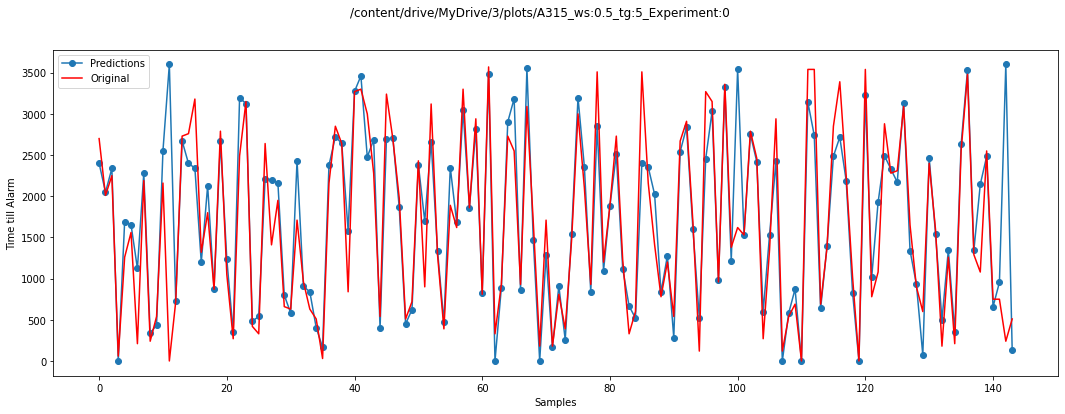

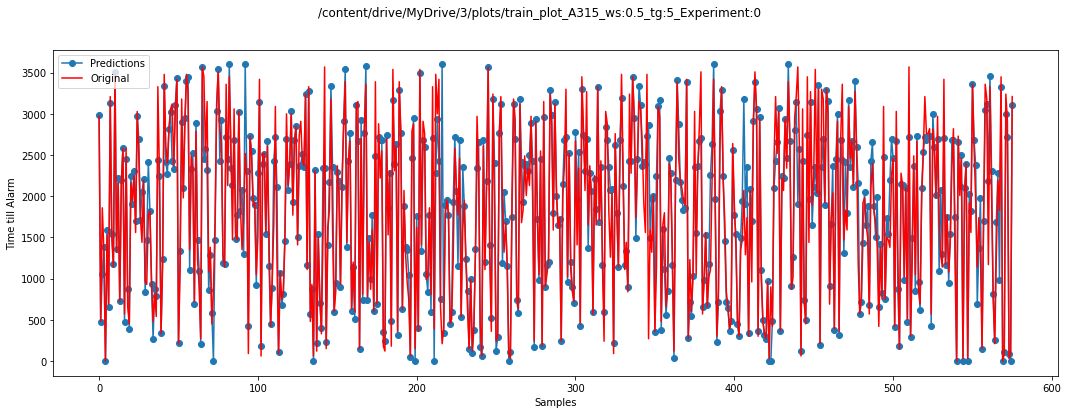

Experiment:  0
Skipping for  A501 
Less than 200 samples for  A501_ws:0.5_tg:5


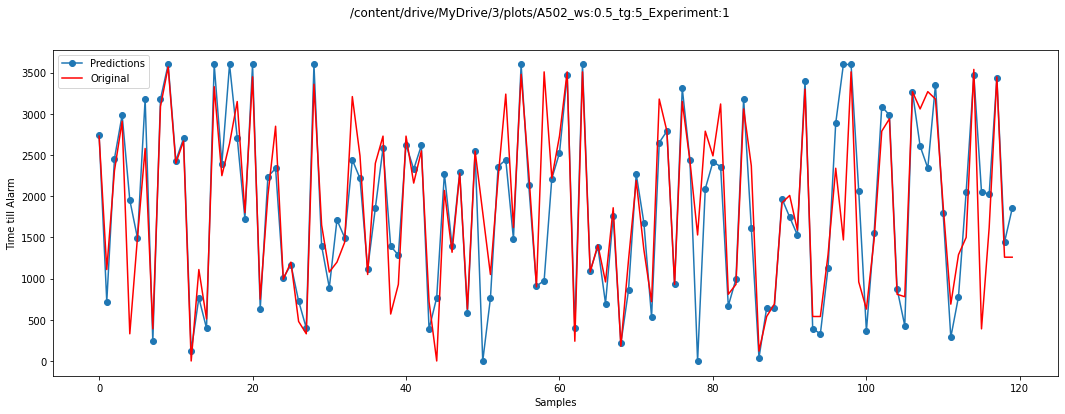

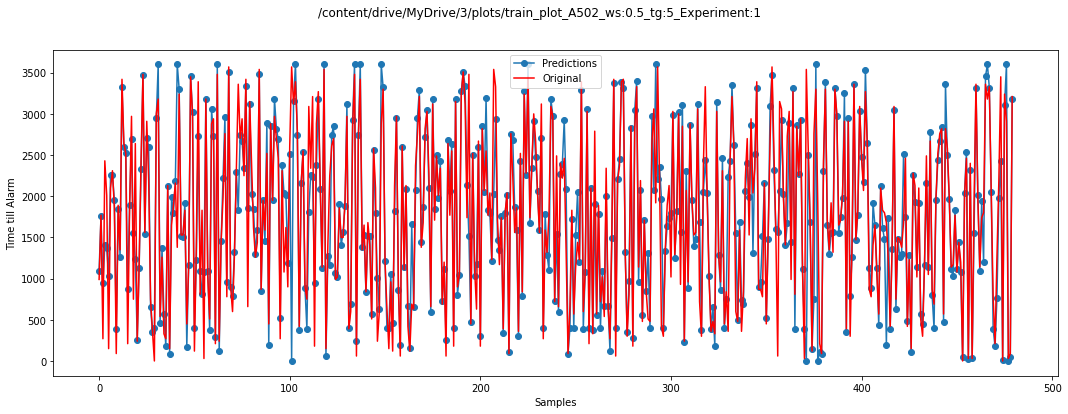

Experiment:  1
Skipping for  A77 
Less than 200 samples for  A77_ws:0.5_tg:5
[Loading preprocessed dataset]
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:0.5_tg:30
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:0.5_tg:30
Skipping for  A315 
Less than 200 samples for  A315_ws:0.5_tg:30
Skipping for  A501 
Less than 200 samples for  A501_ws:0.5_tg:30
Skipping for  A502 
Less than 200 samples for  A502_ws:0.5_tg:30
Skipping for  A77 
Less than 200 samples for  A77_ws:0.5_tg:30
[Loading preprocessed dataset]
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:0.5_tg:60
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:0.5_tg:60
Skipping for  A315 
Less than 200 samples for  A315_ws:0.5_tg:60
Skipping for  A501 
Less than 200 samples for  A501_ws:0.5_tg:60
Skipping for  A502 
Less than 200 samples for  A502_ws:0.5_tg:60
Skipping for  A77 
Less than 200 samples for  A77_ws:0.5_tg:60
[Loading preprocessed dataset]
Skippi

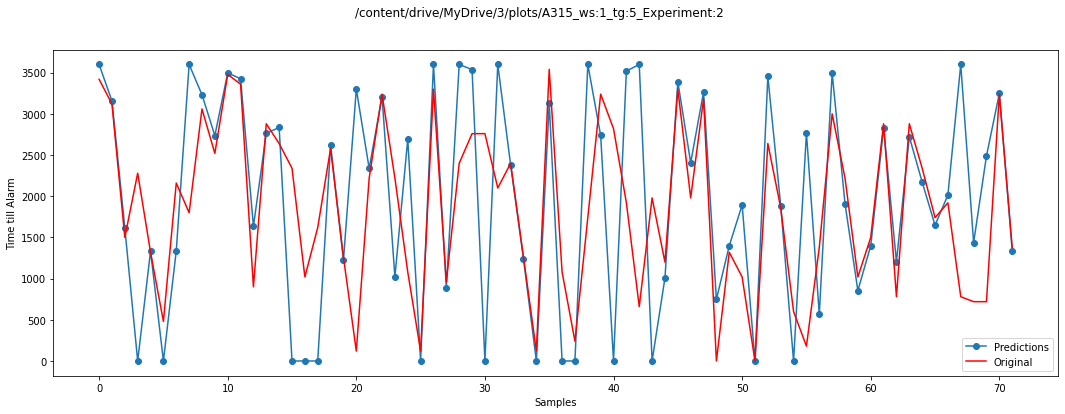

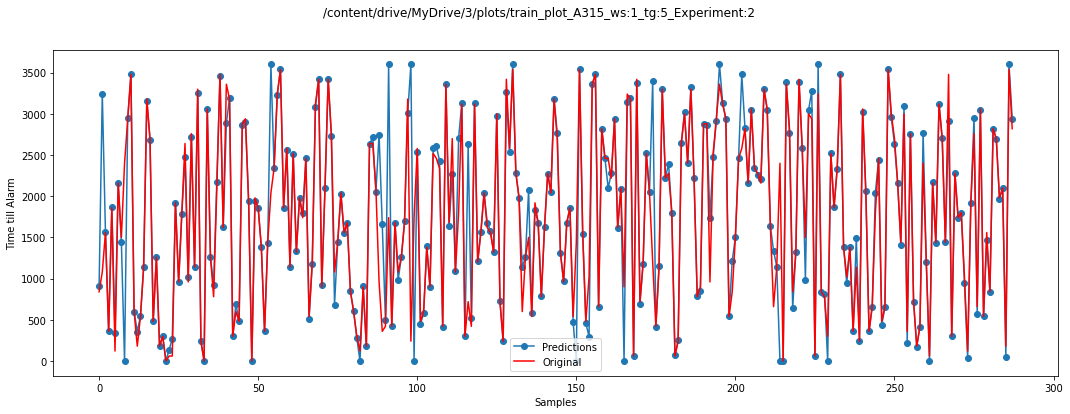

Experiment:  2
Skipping for  A501 
Less than 200 samples for  A501_ws:1_tg:5


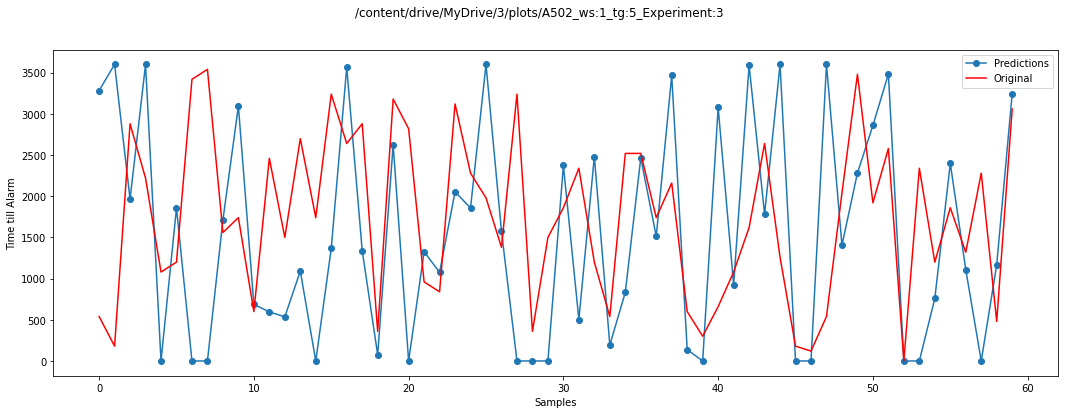

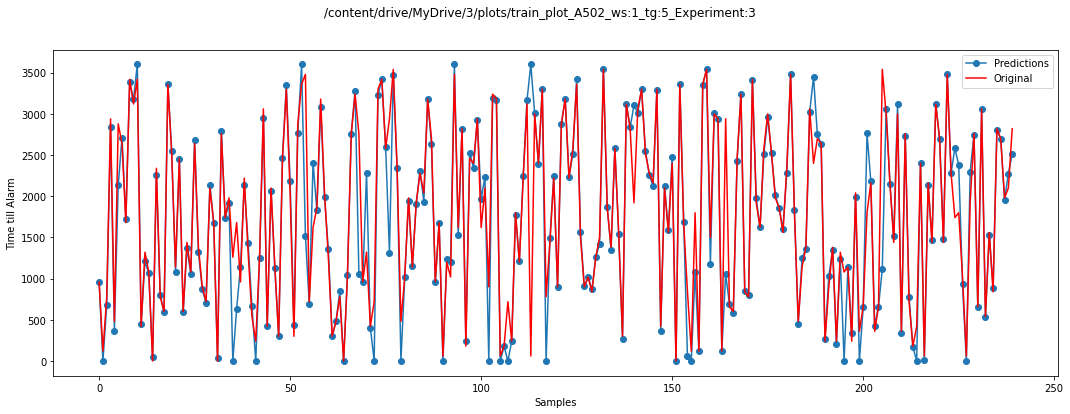

Experiment:  3
Skipping for  A77 
Less than 200 samples for  A77_ws:1_tg:5
[Loading preprocessed dataset]
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:1_tg:30
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:1_tg:30
Skipping for  A315 
Less than 200 samples for  A315_ws:1_tg:30
Skipping for  A501 
Less than 200 samples for  A501_ws:1_tg:30
Skipping for  A502 
Less than 200 samples for  A502_ws:1_tg:30
Skipping for  A77 
Less than 200 samples for  A77_ws:1_tg:30
[Loading preprocessed dataset]
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:1_tg:60
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:1_tg:60
Skipping for  A315 
Less than 200 samples for  A315_ws:1_tg:60
Skipping for  A501 
Less than 200 samples for  A501_ws:1_tg:60
Skipping for  A502 
Less than 200 samples for  A502_ws:1_tg:60
Skipping for  A77 
Less than 200 samples for  A77_ws:1_tg:60
[Loading preprocessed dataset]
Skipping for  A137_UVR_1 
Less t

In [212]:

mint=60                          #seconds per minute
minimum_sec=5                    #minimum sampling time in which data was recorded

# Window size in minutes
window = [0.5,1,2,5]      #window size should be between 0.5 minutes to 60 minutes (should be multiple of minimum and maximum tg)

# Time granuality in seconds
tg = [5,30,60,120]             # Time granuality seconds (how many seconds will be averaged)(must be divisible by 5)

# Perform Vector regression on the root_dir
# for dr in os.listdir(root_dir):
#       if not '.ipynb_checkpoints' in dr and not len(os.listdir(os.path.join(root_dir,dr)))==0:
#             path=os.path.join(root_dir,dr)
#             print(path)
csv_path=train_lr_models_each_alarm(root_dir,window=window,tg=tg)
print("Results saved to: ",csv_path)


## Tensor Regression

tensor([[3570],
        [3540],
        [3510],
        [3480],
        [3450],
        [3420],
        [3390],
        [3360],
        [3330],
        [3300],
        [3270],
        [3240],
        [3210],
        [3180],
        [3150],
        [3120],
        [3090],
        [3060],
        [3030],
        [3000],
        [2970],
        [2940],
        [2910],
        [2880],
        [2850],
        [2820],
        [2790],
        [2760],
        [2730],
        [2700],
        [2670],
        [2640],
        [2610],
        [2580],
        [2550],
        [2520],
        [2490],
        [2460],
        [2430],
        [2400],
        [2370],
        [2340],
        [2310],
        [2280],
        [2250],
        [2220],
        [2190],
        [2160],
        [2130],
        [2100],
        [2070],
        [2040],
        [2010],
        [1980],
        [1950],
        [1920],
        [1890],
        [1860],
        [1830],
        [1800],
        [1770],
        [1740],
        

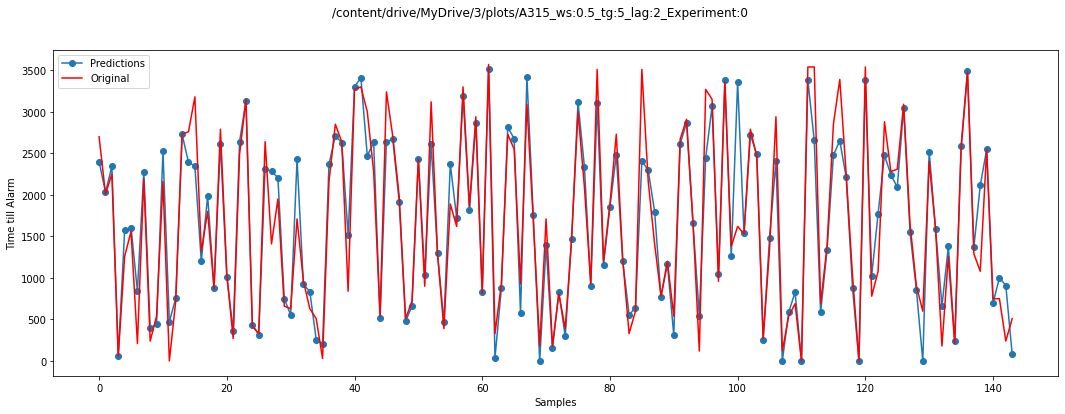

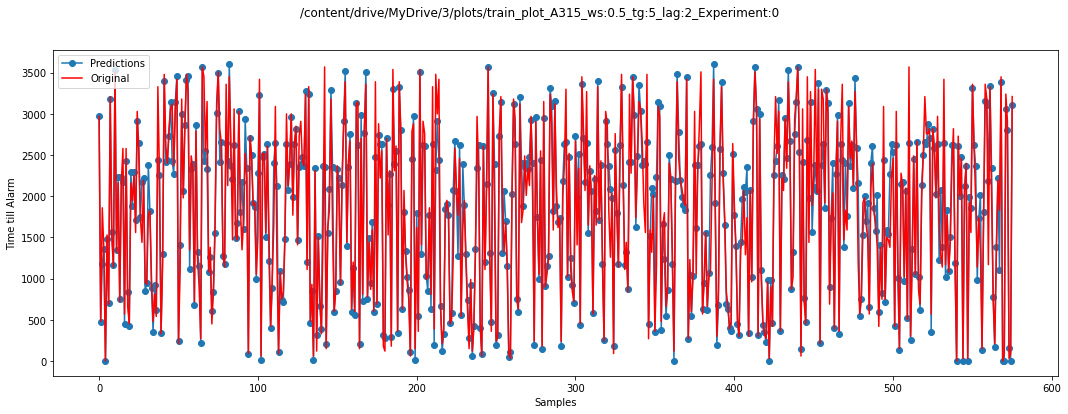

Experiment:  0
120
Skipping for  A501 
Less than 200 samples for  A501_ws:0.5_tg:5_lag:2
600
4008960


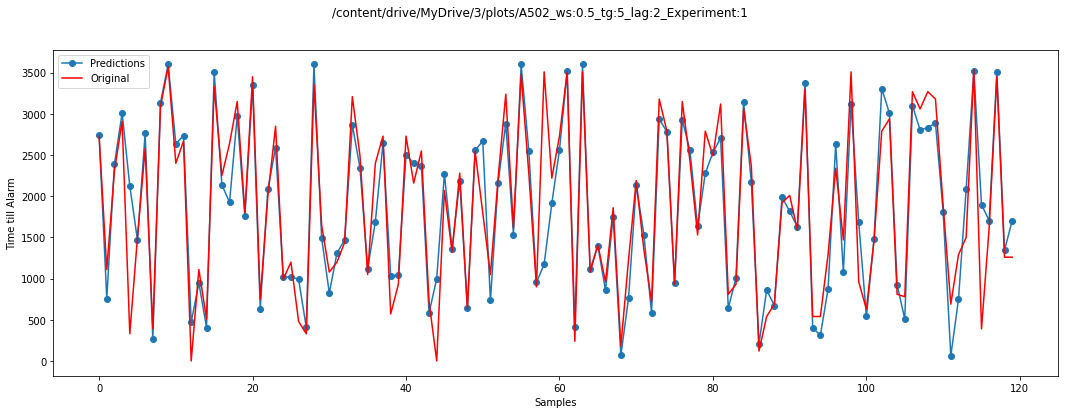

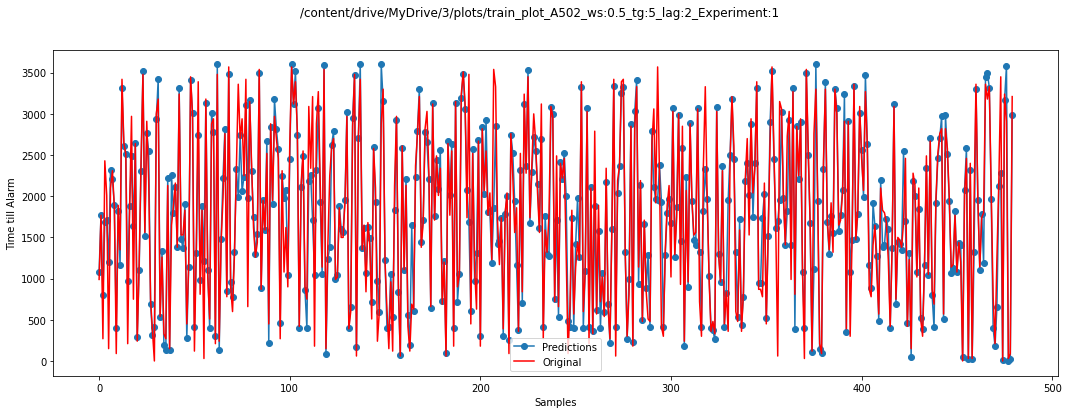

Experiment:  1
120
Skipping for  A77 
Less than 200 samples for  A77_ws:0.5_tg:5_lag:2
20
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:0.5_tg:30_lag:2
20
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:0.5_tg:30_lag:2
120
Skipping for  A315 
Less than 200 samples for  A315_ws:0.5_tg:30_lag:2
20
Skipping for  A501 
Less than 200 samples for  A501_ws:0.5_tg:30_lag:2
100
Skipping for  A502 
Less than 200 samples for  A502_ws:0.5_tg:30_lag:2
20
Skipping for  A77 
Less than 200 samples for  A77_ws:0.5_tg:30_lag:2
10
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:0.5_tg:60_lag:2
10
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:0.5_tg:60_lag:2
60
Skipping for  A315 
Less than 200 samples for  A315_ws:0.5_tg:60_lag:2
10
Skipping for  A501 
Less than 200 samples for  A501_ws:0.5_tg:60_lag:2
50
Skipping for  A502 
Less than 200 samples for  A502_ws:0.5_tg:60_lag:2
10
Skipping for  A77 
Less than 200 samples for  A7

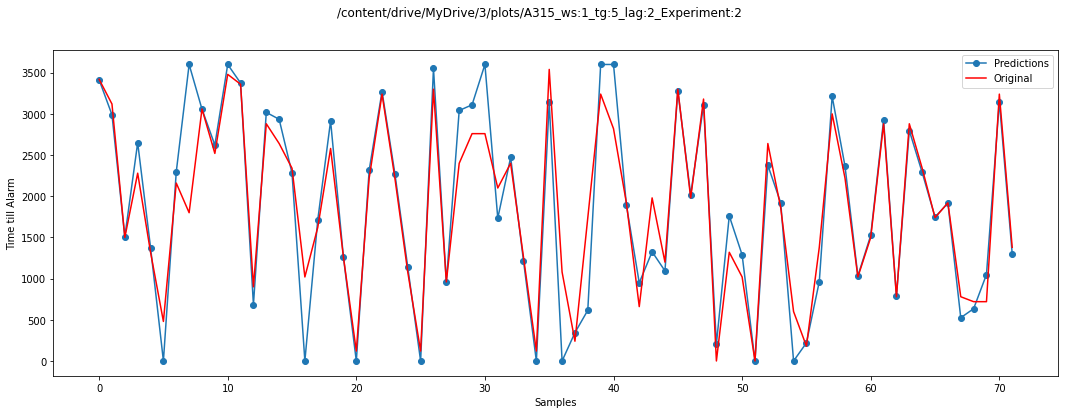

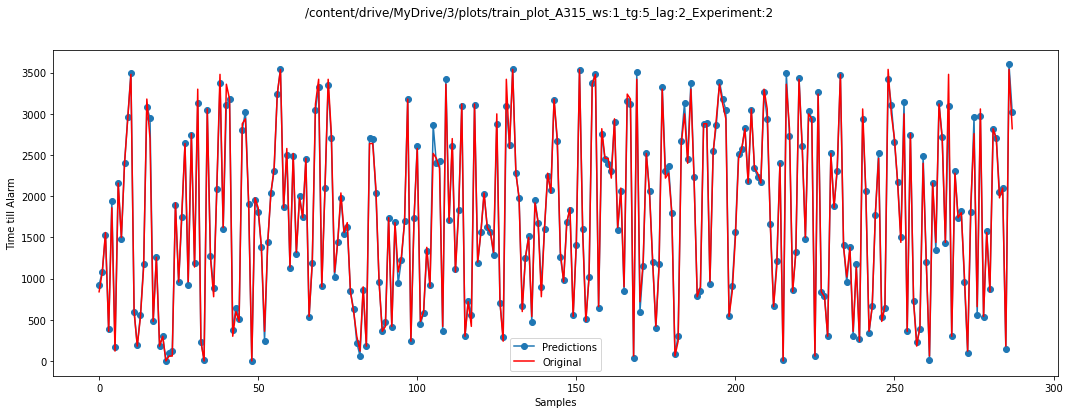

Experiment:  2
60
Skipping for  A501 
Less than 200 samples for  A501_ws:1_tg:5_lag:2
300
8017920


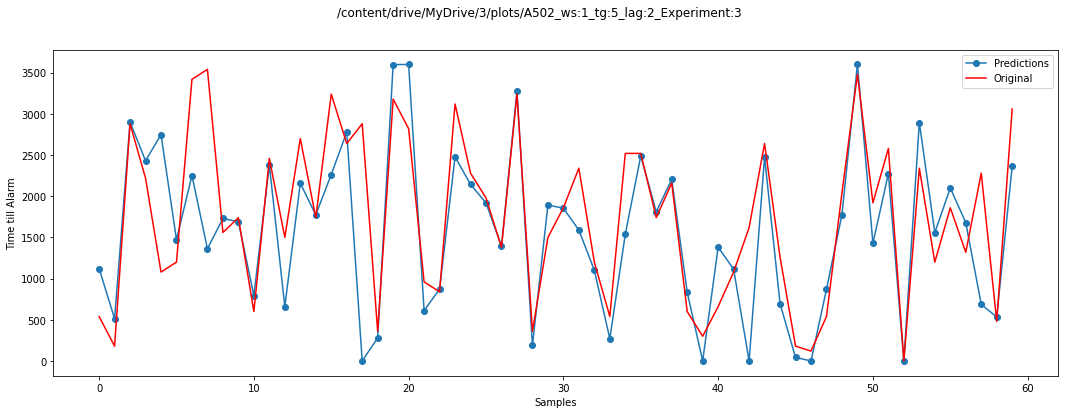

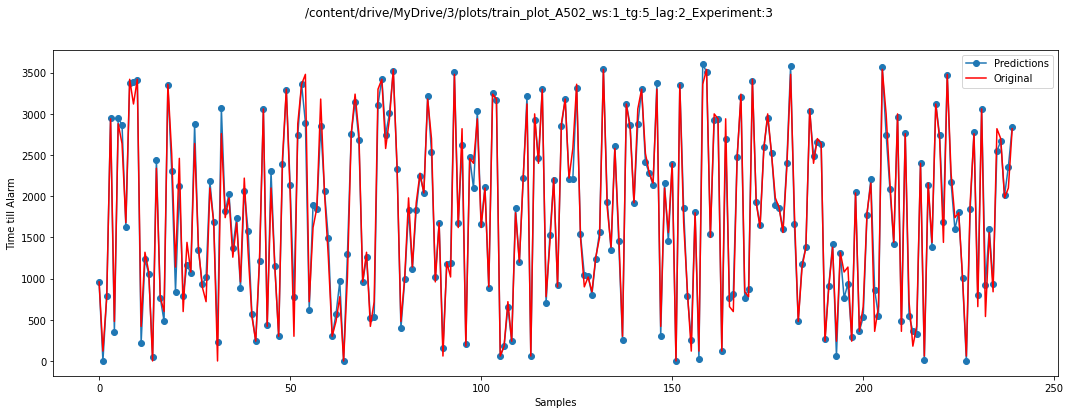

Experiment:  3
60
Skipping for  A77 
Less than 200 samples for  A77_ws:1_tg:5_lag:2
10
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:1_tg:30_lag:2
10
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:1_tg:30_lag:2
60
Skipping for  A315 
Less than 200 samples for  A315_ws:1_tg:30_lag:2
10
Skipping for  A501 
Less than 200 samples for  A501_ws:1_tg:30_lag:2
50
Skipping for  A502 
Less than 200 samples for  A502_ws:1_tg:30_lag:2
10
Skipping for  A77 
Less than 200 samples for  A77_ws:1_tg:30_lag:2
5
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:1_tg:60_lag:2
5
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:1_tg:60_lag:2
30
Skipping for  A315 
Less than 200 samples for  A315_ws:1_tg:60_lag:2
5
Skipping for  A501 
Less than 200 samples for  A501_ws:1_tg:60_lag:2
25
Skipping for  A502 
Less than 200 samples for  A502_ws:1_tg:60_lag:2
5
Skipping for  A77 
Less than 200 samples for  A77_ws:1_tg:60_lag:2
30
Skipping 

In [232]:

cp_components=15            #required for tensor regression

mint=60                          #seconds per minute
minimum_sec=5                    #minimum sampling time in which data was recorded

# Window size in minutes
window = [0.5,1,2,5]      #window size should be between 0.5 minutes to 60 minutes (should be multiple of minimum and maximum tg)

# Time granuality in seconds
tg = [5,30,60,120]             # Time granuality seconds (how many seconds will be averaged)(must be divisible by 5)

lag=[2]   # lag in seconds (2 means lag of time samples)
# for dr in os.listdir(root_dir):
#     path=os.path.join(root_dir,dr)
#     # Perform Tensor regression on the root_dir
#     print(path)
csv_path=hankle_and_train_tensor_regression(root_dir, window=window, tg=tg, lag=lag, cp_components=cp_components,model='reg')
print("Results saved to: ",csv_path)


## Matrix Regression using CP Regression

[Loading preprocessed dataset]
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:0.5_tg:5
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:0.5_tg:5


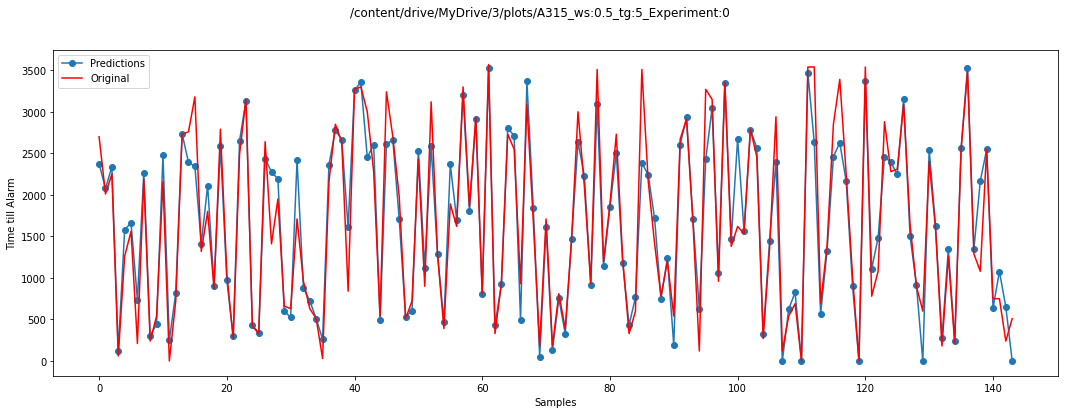

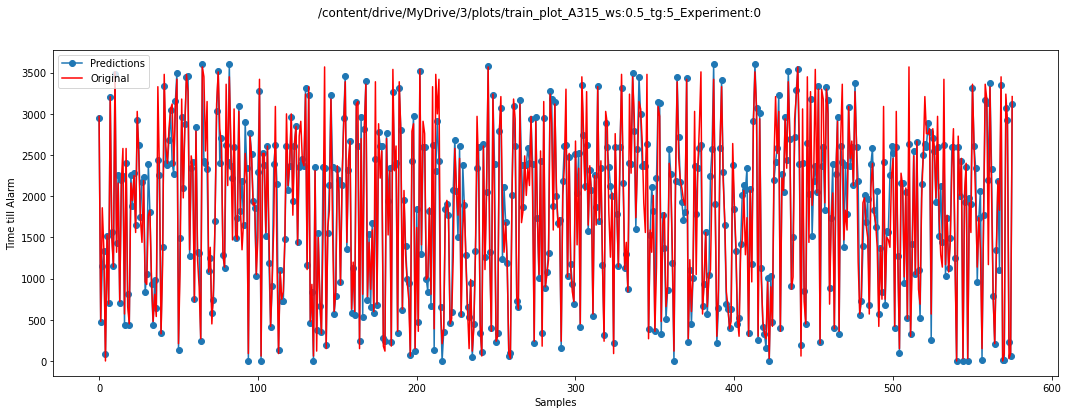

Experiment:  0
Skipping for  A501 
Less than 200 samples for  A501_ws:0.5_tg:5


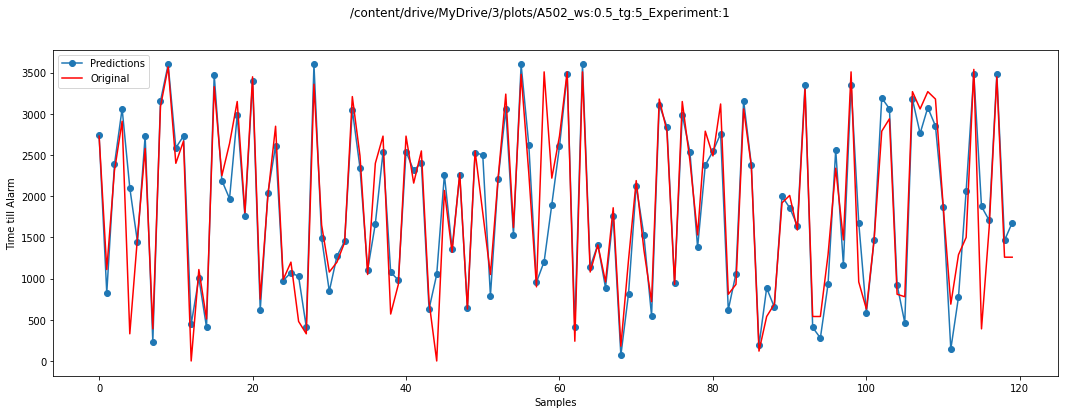

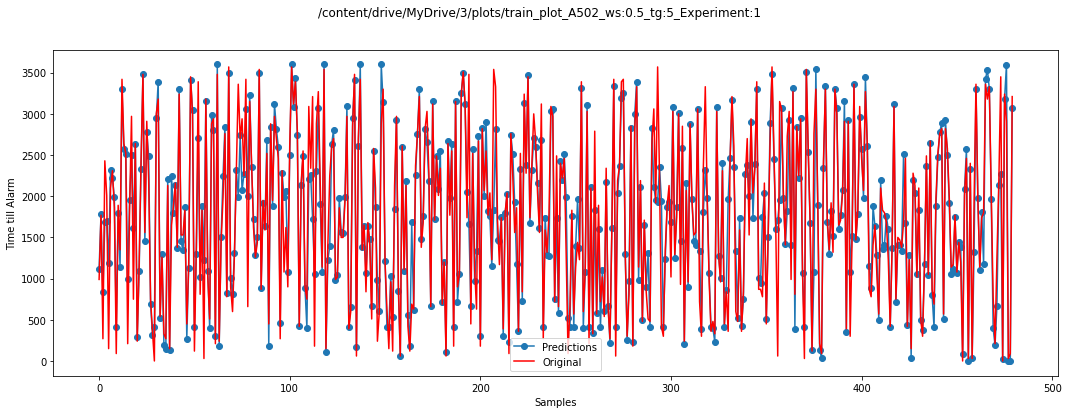

Experiment:  1
Skipping for  A77 
Less than 200 samples for  A77_ws:0.5_tg:5
[Loading preprocessed dataset]
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:0.5_tg:30
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:0.5_tg:30
Skipping for  A315 
Less than 200 samples for  A315_ws:0.5_tg:30
Skipping for  A501 
Less than 200 samples for  A501_ws:0.5_tg:30
Skipping for  A502 
Less than 200 samples for  A502_ws:0.5_tg:30
Skipping for  A77 
Less than 200 samples for  A77_ws:0.5_tg:30
[Loading preprocessed dataset]
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:0.5_tg:60
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:0.5_tg:60
Skipping for  A315 
Less than 200 samples for  A315_ws:0.5_tg:60
Skipping for  A501 
Less than 200 samples for  A501_ws:0.5_tg:60
Skipping for  A502 
Less than 200 samples for  A502_ws:0.5_tg:60
Skipping for  A77 
Less than 200 samples for  A77_ws:0.5_tg:60
[Loading preprocessed dataset]
Skippi

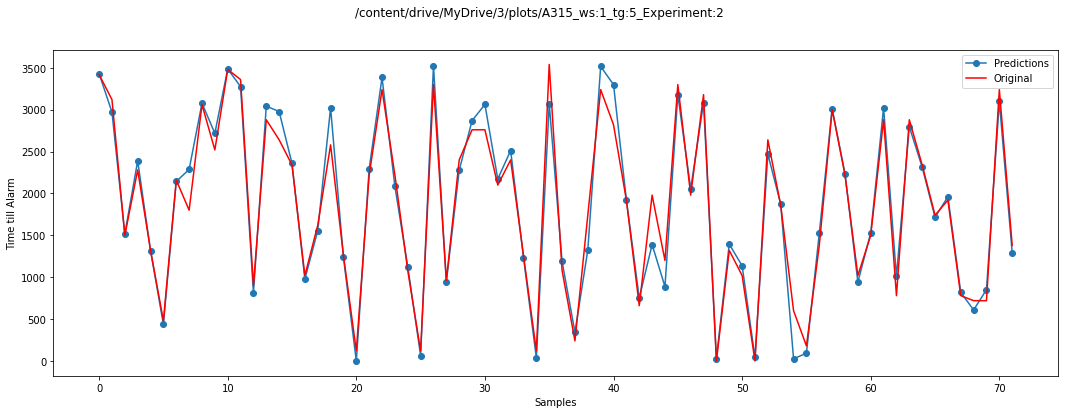

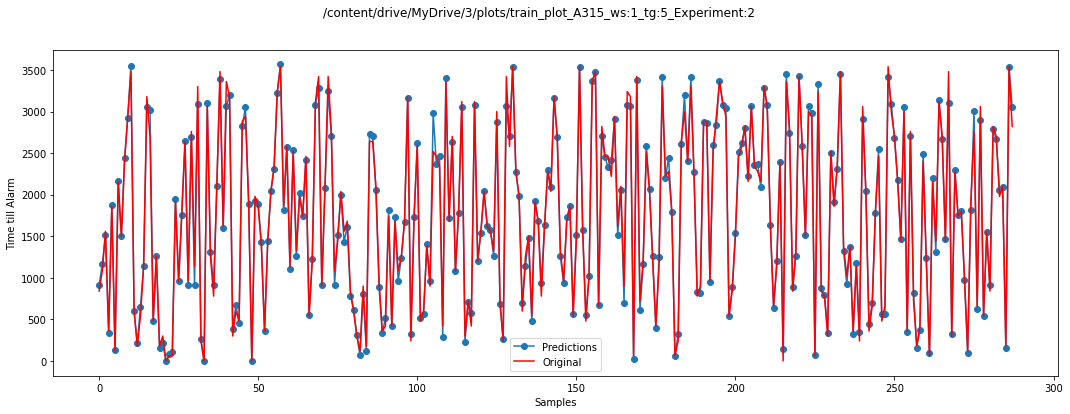

Experiment:  2
Skipping for  A501 
Less than 200 samples for  A501_ws:1_tg:5


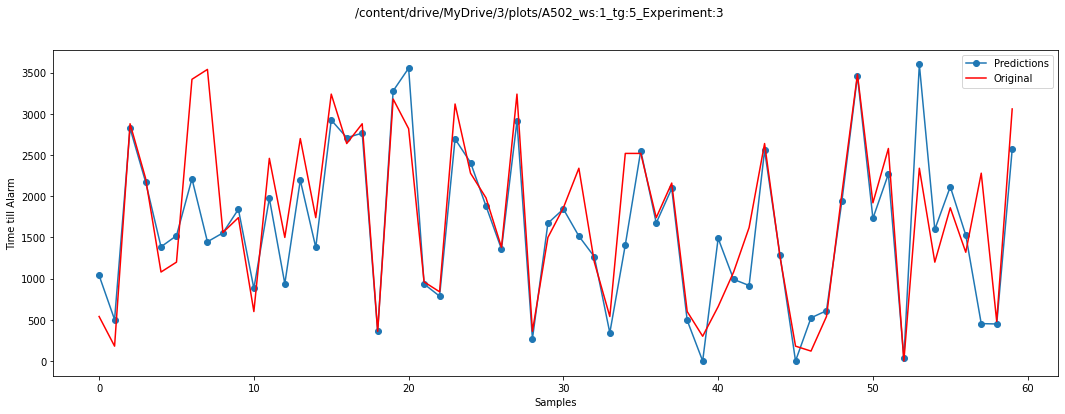

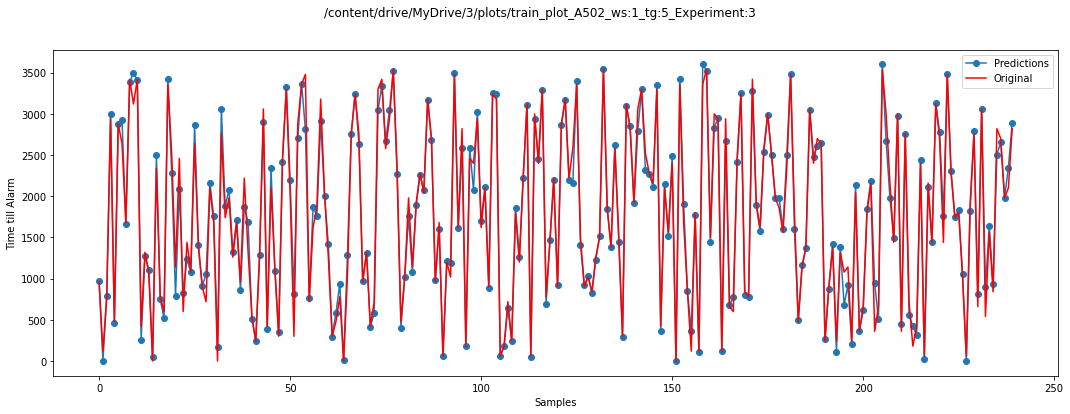

Experiment:  3
Skipping for  A77 
Less than 200 samples for  A77_ws:1_tg:5
[Loading preprocessed dataset]
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:1_tg:30
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:1_tg:30
Skipping for  A315 
Less than 200 samples for  A315_ws:1_tg:30
Skipping for  A501 
Less than 200 samples for  A501_ws:1_tg:30
Skipping for  A502 
Less than 200 samples for  A502_ws:1_tg:30
Skipping for  A77 
Less than 200 samples for  A77_ws:1_tg:30
[Loading preprocessed dataset]
Skipping for  A137_UVR_1 
Less than 200 samples for  A137_UVR_1_ws:1_tg:60
Skipping for  A138_UVR_1 
Less than 200 samples for  A138_UVR_1_ws:1_tg:60
Skipping for  A315 
Less than 200 samples for  A315_ws:1_tg:60
Skipping for  A501 
Less than 200 samples for  A501_ws:1_tg:60
Skipping for  A502 
Less than 200 samples for  A502_ws:1_tg:60
Skipping for  A77 
Less than 200 samples for  A77_ws:1_tg:60
[Loading preprocessed dataset]
Skipping for  A137_UVR_1 
Less t

In [233]:
cp_components=15              #required for tensor regression

mint=60                          #seconds per minute

minimum_sec=5                    #minimum sampling time in which data was recorded

# Window size in minutes
window = [0.5,1,2,5]      #window size should be between 0.5 minutes to 60 minutes (should be multiple of minimum and maximum tg)

# Time granuality in seconds
tg = [5,30,60,120]             # Time granuality seconds (how many seconds will be averaged)(must be divisible by 5)

# Perform Tensor regression on the root_dir
# for dr in os.listdir(root_dir):
#     path=os.path.join(root_dir,dr)
#     print(path)
csv_path=hankle_and_train_matrix_regression(root_dir, window=window, tg=tg, cp_components=cp_components)
print("Results saved to: ",csv_path)


## Loading Train Data

In [ ]:
'''
data_path="/content/drive/MyDrive/SmartAlarm/15"
for f in os.listdir(data_path):
    if '_data_folder' in f:
        print(f)
        train_data_path = data_path+'/'+f
        print("\nData type: ",f.split('_')[0].upper())
        for data in os.listdir(train_data_path):
            print("\nModel configuration: ",data.split('.')[0].split('_')[1:])
            load_path=train_data_path+'/'+data
            if data.split('.')[-1]=='pickle':
                with open(load_path, 'rb') as ds:
                    alarms_dataset = pickle.load(ds)
                    for i,ds in alarms_dataset.items():
                          alarm_name = pd.read_csv(data_path+'/classes.csv' ,header=None)[0].iloc[i]
                          print("Alarm: ",alarm_name)
                          x,y=ds
                          if not 'vector' in f:
                              x=x.cpu().numpy()
                              y=y.cpu().numpy()
                          if 'vector' in f:
                              x = pd.DataFrame(x)
                              y = pd.DataFrame(y)
                          print("X shape: ",x.shape)
                          print("Y.shape: ",y.shape)
                          # print("X: ",x) ## print dataset
                          # print("Y: ",y) ## print Y labels
          '''                


In [218]:
def prepare_data_vector_single_alarm(root_dir,alarm_name,window=30,tg=5,model='reg'):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    print("Dimensions of Original Dataset:\nX has dimension",X.shape,"\nY has dimension",Y.shape)
    cv=5
    dataset_name = os.path.split(root_dir)[-1]
    print("Machine:",dataset_name)
    w1,t1=int((window*60)//5), tg//5 
    if 720//t1 % w1 !=0:
        print("Setting not valid")   
        sys.exit()             

    df = pd.read_csv(root_dir+'/classes.csv' ,header=None)
    for i, row in df.iterrows():
        if alarm_name in row.values:
            index = i    

    xe,ye = select_alarms(X,Y,alarm_select=index)
    print("Filtering the normal samples, selecting",alarm_name,\
          "from the Original Dataset:\nX has dimension",xe.shape[1:],\
          "\nY has dimension",ye.shape[1:])
    print("Total Number of alarm samples for",alarm_name,"are",ye.shape[1],"samples.")
    print("\nEach sample is average using time granuality and split into windows one by one:")
    alarm_ds = divide_and_create_lr_datasets(xe,list(ye), window=w1, tg=t1, detail=1)
    for i,ds in alarm_ds.items():
        x,y= ds

    print("\nTotal Number of windows are",ye.shape[1],"*",720//t1//w1,"=",x.shape[0])
    print("Shape of X respectively: ",x.shape)
    print("Shape of Y respectively: ",y.shape)
    return x,y

In [219]:
x,y=prepare_data_vector_single_alarm(root_dir, "A315", tg=5,window=2)
print(x)
print(y)

Dimensions of Original Dataset:
X has dimension (175, 58, 720) 
Y has dimension (175, 1)
Machine: 3
Filtering the normal samples, selecting A315 from the Original Dataset:
X has dimension (6, 58, 720) 
Y has dimension (6,)
Total Number of alarm samples for A315 are 6 samples.

Each sample is average using time granuality and split into windows one by one:

Dividing the X data into windows, 
Original shape (features, time): (58, 720)
Taking time granuality by taking average of every 5 seconds, 
New shape (features, time): (58, 720)
Dividing the data into windows of 24 samples each, total windows: 30
New shape (features, time, windows): (58, 24, 30)
Multiply feature dimension with time for vector regression, 
New shape (features * time, windows): (1392, 30)
New shape of X after applying time granuality and window split, 
New shape (windows, features * time): (30, 1392)
Shape of Y created using X: (30, 1)

Dividing the X data into windows, 
Original shape (features, time): (58, 720)
Takin

In [226]:
def prepare_data_tensor_single_alarm(root_dir,alarm_name,window=30,tg=5,lag=2,model='reg'):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    print("Dimensions of Original Dataset:\nX has dimension",X.shape,"\nY has dimension",Y.shape)
    cv=5
    dataset_name = os.path.split(root_dir)[-1]
    print("Machine:",dataset_name)
    w1,t1=int((window*60)//5), tg//5 
    if 720//t1 % w1 !=0:
        print("Setting not valid")   
        sys.exit()             

    df = pd.read_csv(root_dir+'/classes.csv' ,header=None)
    for i, row in df.iterrows():
        if alarm_name in row.values:
            index = i    

    xe,ye = select_alarms(X,Y,alarm_select=index)
    print("Filtering the normal samples, selecting",alarm_name,\
          "from the Original Dataset:\nX has dimension",xe.shape[1:],\
          "\nY has dimension",ye.shape[1:])
    print("Total Number of alarm samples for",alarm_name,"are",ye.shape[1],"samples.")
    print("\nEach sample is average using time granuality, split into windows and hankelize one by one:")
    alarm_ds = divide_and_create_tr_datasets(xe,list(ye), window=w1, tg=t1, lag=lag,detail=1)
    for i,ds in alarm_ds.items():
        x,y= ds

    print("\nTotal Number of windows are",ye.shape[1],"*",720//t1//w1,"=",x.shape[0])
    print("Shape of X respectively: ",x.cpu().numpy().shape)
    print("Shape of Y respectively: ",y.cpu().numpy().shape)
    return x.cpu().numpy(),y.cpu().numpy()

In [227]:
x,y=prepare_data_tensor_single_alarm(root_dir, "A315", tg=5,window=2,lag=4)
print(x)
print(y)

Dimensions of Original Dataset:
X has dimension (175, 58, 720) 
Y has dimension (175, 1)
Machine: 3
Filtering the normal samples, selecting A315 from the Original Dataset:
X has dimension (6, 58, 720) 
Y has dimension (6,)
Total Number of alarm samples for A315 are 6 samples.

Each sample is average using time granuality, split into windows and hankelize one by one:

Dividing the X data into windows, 
Original shape (features, time): (58, 720)
Taking time granuality by taking average of every 5 seconds, 
New shape (features, time): (58, 720)
Dividing the data into windows of 24 samples each, total windows: 30
New shape (features, time, windows): (58, 24, 30)
Transposing the dimensions for tensor regression, 
New shape (windows, features, time): (30, 58, 24)
Hankelizing with lag in samples: 4 
New shape (windows, features, time, lag): (30, 58, 24, 6)
New shape of X after applying time granuality and window split,         
New shape (windows, features, time, lag): (30, 58, 24, 6)
Shape o

In [228]:
def prepare_data_matrix_single_alarm(root_dir,alarm_name,window=30,tg=5,model='reg'):
    x_train,y_train,x_test,y_test = load_data(root_dir)
    X=np.vstack([x_train,x_test])
    Y=np.vstack([y_train,y_test])
    print("Dimensions of Original Dataset:\nX has dimension",X.shape,"\nY has dimension",Y.shape)
    cv=5
    dataset_name = os.path.split(root_dir)[-1]
    print("Machine:",dataset_name)
    w1,t1=int((window*60)//5), tg//5 
    if 720//t1 % w1 !=0:
        print("Setting not valid")   
        sys.exit()             

    df = pd.read_csv(root_dir+'/classes.csv' ,header=None)
    for i, row in df.iterrows():
        if alarm_name in row.values:
            index = i    

    xe,ye = select_alarms(X,Y,alarm_select=index)
    print("Filtering the normal samples, selecting",alarm_name,\
          "from the Original Dataset:\nX has dimension",xe.shape[1:],\
          "\nY has dimension",ye.shape[1:])
    print("Total Number of alarm samples for",alarm_name,"are",ye.shape[1],"samples.")
    print("\nEach sample is average using time granuality and split into windows one by one:")
    alarm_ds = divide_and_create_matrix_datasets(xe,list(ye), window=w1, tg=t1, detail=1)
    for i,ds in alarm_ds.items():
        x,y= ds

    print("\nTotal Number of windows are",ye.shape[1],"*",720//t1//w1,"=",x.shape[0])
    print("Shape of X respectively: ",x.cpu().numpy().shape)
    print("Shape of Y respectively: ",y.cpu().numpy().shape)
    return x.cpu().numpy(),y.cpu().numpy()

In [229]:
x,y=prepare_data_matrix_single_alarm(root_dir, "A315", tg=5,window=2)
print(x)
print(y)

Dimensions of Original Dataset:
X has dimension (175, 58, 720) 
Y has dimension (175, 1)
Machine: 3
Filtering the normal samples, selecting A315 from the Original Dataset:
X has dimension (6, 58, 720) 
Y has dimension (6,)
Total Number of alarm samples for A315 are 6 samples.

Each sample is average using time granuality and split into windows one by one:
(58, 720)

Dividing the X data into windows, 
Original shape (features, time): (58, 720)
Taking time granuality by taking average of every 5 seconds, 
New shape (features, time): (58, 720)
Dividing the data into windows of 24 samples each, total windows: 30
New shape (features, time, windows): (58, 24, 30)
Transposing the dimensions for tensor regression, 
New shape (windows, features, time): (58, 24, 30)
New shape of X after applying time granuality and window split, 
New shape (windows, features, time): (30, 58, 24)
Shape of Y created using X: (30, 1)

Dividing the X data into windows, 
Original shape (features, time): (58, 720)
Tak